# Introduction to the project

Here starts the final project of the Master in Data Science at KSCHOOL, done by Pablo Fernández Matus. The name of this project is "Spanish La Liga Predictions" and it is realised during the first half of year 2021.

During this project work will be carried out with data related to soccer matches results, from which will be extracted relevant information in order to build a prediction model. The type of model, and what it will consist on are decissions that would be made as the content of the data being worked on becomes better understood.

The project is divided into different notebooks following the steps taken for the data processing, algorithm execution and data analysis. This final step is performed via Tableau dashboards operating as the front-end of the project.

All the notebooks that make up this project can be found in the following repository, including the Tableau file that contains the Front-end.

https://github.com/PabloMatus6/Spanish-LaLiga-Round-Prediction

In terms of software or licences required to run this program, it is sufficient to have access to Jupyter Notebook for the code. To view the front-end in Tableau, you will need a Tableau account or request the free trial offered by Tableau desktop.

# Imports

In [238]:
import pandas as pd 
import numpy as np
import os 
import requests
import json
import matplotlib.pyplot as plt 
from pandas import DataFrame
import numpy as np
import seaborn as sns
from seaborn import boxplot
from seaborn import swarmplot
from seaborn import scatterplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification

# 0.- Before starting

This version, All-in-one, compiles the entire project in a single notebook. It was decided to make this version to facilitate the replicability of the project in case you want to make the request directly to the API. 

In this notebook, the problem of the absence of data for the 2015-16 season is solved by removing this season from the requests. Therefore, in this version of the project, the model will consist of 5 seasons of the first two Spanish football divisions, La Liga Santander and La Liga Smartbank. It is obvious that the number of rows will be different and therefore the results will be different as well.

This version has the sole objective of facilitating the replicability of the project, so the comments regarding the results obtained in it will be omitted.
The intermediate csv file uploads used in the original version between notebook and notebook will be maintained. 

# 01.- Requesting data

## 1.- Requests

### 1.1- Matches Request

The project starts with the data request from La Liga Santander & La Liga Smartbank matches in the last 5 years. This request is done via the BeSoccer API. A personal key for the requests is not needed as it is already configured in the notebook. 

In case this key stops working in the future, it will be necessary to request a temporary free account to the Besoccer API, and enter the key that is received replacing the old one in the links of the requests.

In [2]:
for league_division in range(1, 3):
    for league_season in range(2017, 2022):
        for league_round in range(1, 39):
            matches_url = f"https://apiclient.besoccerapps.com/scripts/api/api.php?key=023afbc77c5610fefc3fc8976e451752&tz=Europe/Madrid&format=json&req=matchs&league={league_division}&round={league_round}&order=twin&twolegged=1&year={league_season}"
            response = requests.get(matches_url)
            result = json.loads(response.content)
            if league_round == 1 and league_division == 1 and league_season == 2017:
                df1 = pd.DataFrame(result['match'])
            else:
                df1 = df1.append(result['match'])

In [3]:
df1.head(5)

,id,year,group,total_group,round,local,visitor,league_id,stadium,team1,...,visitor_goals,result,live_minute,status,channels,winner,penaltis1,penaltis2,prorroga,stadium2
0,96233,2017,1,1,1,Málaga,Osasuna,30626,La Rosaleda,704143,...,1,1-1,,1,"[{'id': '20', 'name': 'Gol', 'image': 'https:/...",0,0,0,False,NaN
1,96229,2017,1,1,1,Deportivo,Eibar,30626,Municipal Riazor,704138,...,1,2-1,,1,"[{'id': '185', 'name': 'beIN LaLiga', 'image':...",704138,0,0,False,NaN
2,96226,2017,1,1,1,Barcelona,Real Betis,30626,Camp Nou,704136,...,2,6-2,,1,"[{'id': '185', 'name': 'beIN LaLiga', 'image':...",704136,0,0,False,NaN
3,96230,2017,1,1,1,Granada,Villarreal,30626,Nuevo Los Cármenes,704141,...,1,1-1,,1,"[{'id': '185', 'name': 'beIN LaLiga', 'image':...",0,0,0,False,NaN
4,96228,2017,1,1,1,Sevilla,Espanyol,30626,Ramón Sánchez Pizjuán,704147,...,4,6-4,,1,"[{'id': '185', 'name': 'beIN LaLiga', 'image':...",704147,0,0,False,NaN


We realise that we need to add for La Liga Smartbank four more rounds, as this division has two more teams, there are 42 rounds instead of 38. However, after several tests, adding it is problematic and the information can be confusing, as in the first division these rounds are not available, so it was finally decided not to add it. 

At this point, we decide to save the entire dataframe before we start working on it and it undergoes modifications.

In [4]:
df1.to_csv('matches_request')

### 1.2.- Standings Request

The second request is then made to complete the information already available. In this request, information is requested about the league table according to the round, division and season of each team at the mometn of the match.

In [5]:
for league_division in range(1, 3):
    for league_season in range(2017, 2022):
        for league_round in range(1, 39):
            standings_url = f"https://apiclient.besoccerapps.com/scripts/api/api.php?key=023afbc77c5610fefc3fc8976e451752&tz=Europe/Madrid&format=json&req=tables&league={league_division}&round={league_round}&year={league_season}"
            response_standings = requests.get(standings_url)
            result_standings = json.loads(response_standings.content)
            if league_round == 1 and league_division == 1 and league_season == 2017:
                df3 = pd.DataFrame(result_standings['table'])
            else:
                df3 = df3.append(result_standings['table'])

In [6]:
df3.head(5)

,id,group,group_name,conference,team,points,wins,draws,losses,shield,...,coef,coefficients,mark,class_mark,round,pos,countrycode,abbr,form,direction
0,429,1,Liga Santander,0,Barcelona,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,,None,1,cha,1,1,ES,FCB,w,
1,2107,1,Liga Santander,0,Real Madrid,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,,None,1,cha,1,2,ES,RMA,w,
2,1102,1,Liga Santander,0,Sevilla,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,,None,1,cha,1,3,ES,SEV,w,
3,2563,1,Liga Santander,0,Las Palmas,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,,None,2,prev,1,4,ES,UDL,w,
4,901,1,Liga Santander,0,Deportivo,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,,None,3,uefa,1,5,ES,DEP,w,


In [7]:
df3.columns

Index(['id', 'group', 'group_name', 'conference', 'team', 'points', 'wins',
       'draws', 'losses', 'shield', 'cflag', 'basealias', 'gf', 'ga', 'avg',
       'matchs_coef', 'points_coef', 'coef', 'coefficients', 'mark',
       'class_mark', 'round', 'pos', 'countrycode', 'abbr', 'form',
       'direction'],
      dtype='object')

In [8]:
df3 = df3.drop(['group', 'group_name', 'conference', 'shield', 'cflag', 'basealias',
       'matchs_coef', 'points_coef', 'coef', 'coefficients', 'mark',
       'class_mark', 'countrycode', 'abbr',
       'direction'] , axis = 1 )

In [9]:
df3.tail()

,id,team,points,wins,draws,losses,gf,ga,avg,round,pos,form
17,673,CD Castellón,41,11,8,19,35,44,-9,38,18,lwddl
18,1578,UD Logroñés,41,10,11,17,26,47,-21,38,19,wdldl
19,2198,Sabadell,40,9,13,16,36,44,-8,38,20,ddwwl
20,1598,Lugo,37,8,13,17,32,50,-18,38,21,llldl
21,140,Albacete,36,9,9,20,25,46,-21,38,22,lwdlw


There is some information left in this request that we need to be able to do de merge with the DataFrame created by Matches request. 

In [11]:
for league_division in range(1, 3):
    for league_season in range(2017, 2022):
        for round_num in range(1, 39):
            standings_url_bis = f"https://apiclient.besoccerapps.com/scripts/api/api.php?key=023afbc77c5610fefc3fc8976e451752&tz=Europe/Madrid&format=json&req=tables&league={league_division}&round={round_num}&year={league_season}"
            response_standings_bis = requests.get(standings_url_bis)
            result_standings_bis = json.loads(response_standings_bis.content)
            if league_division == 1 and league_season == 2017 and round_num == 1:
                df4 = pd.DataFrame(result_standings_bis['table'])
                df4['year'] = league_season
                df4['division'] = league_division
            else:
                df4_bis = pd.DataFrame(result_standings_bis['table'])
                df4_bis['year'] = league_season
                df4_bis['division'] = league_division
                df4 = pd.concat([df4, df4_bis])

In [12]:
df4.tail()

,id,group,group_name,conference,team,points,wins,draws,losses,shield,...,mark,class_mark,round,pos,countrycode,abbr,form,direction,year,division
17,673,1,,0,CD Castellón,41,11,8,19,https://thumb.resfu.com/img_data/escudos/mediu...,...,,,38,18,ES,CAS,lwddl,,2021,2
18,1578,1,,0,UD Logroñés,41,10,11,17,https://thumb.resfu.com/img_data/escudos/mediu...,...,3,desc,38,19,ES,UDL,wdldl,d,2021,2
19,2198,1,,0,Sabadell,40,9,13,16,https://thumb.resfu.com/img_data/escudos/mediu...,...,3,desc,38,20,ES,SAB,ddwwl,d,2021,2
20,1598,1,,0,Lugo,37,8,13,17,https://thumb.resfu.com/img_data/escudos/mediu...,...,3,desc,38,21,ES,LUG,llldl,,2021,2
21,140,1,,0,Albacete,36,9,9,20,https://thumb.resfu.com/img_data/escudos/mediu...,...,3,desc,38,22,ES,ALB,lwdlw,,2021,2


Proceed in the same way to save the dataframe extracted from this request. In this way, two dataframes are available and must be joined into one, using the information they have in common.

In [13]:
df4.to_csv('standings_request')

# 02.- Merging Requests

## 1.- CSV files loads

In this notebook, the two .csv files saved in the previous notebook will be loaded. Both dataframes are prepared in order to merge them into one.

In [14]:
matches_request = pd.read_csv('matches_request', index_col = [0])

Columns that are not visually necessary are removed, and the remaining columns will be evaluated at a later stage.

In [15]:
matches_request.columns

Index(['id', 'year', 'group', 'total_group', 'round', 'local', 'visitor',
       'league_id', 'stadium', 'team1', 'team2', 'conference', 'dteam1',
       'dteam2', 'numc', 'no_hour', 'local_abbr', 'visitor_abbr', 'isVideo',
       'numVideos', 'competition_name', 'competition_id', 'split_league',
       'type', 'type_id', 'playoffs', 'group_code', 'total_rounds', 'coef',
       'cflag_local', 'cflag_visitor', 'local_shield', 'visitor_shield',
       'extraTxt', 'schedule', 'date', 'hour', 'minute', 'local_goals',
       'visitor_goals', 'result', 'live_minute', 'status', 'channels',
       'winner', 'penaltis1', 'penaltis2', 'prorroga', 'stadium2'],
      dtype='object')

In [16]:
matches_merge = matches_request.drop(['stadium', 'group', 'total_group', 'no_hour', 'status', 'isVideo', 'playoffs', 'penaltis1', 'penaltis2', 'prorroga', 'stadium2', 'channels','hour','minute', 'extraTxt', 'cflag_local', 'cflag_visitor','conference','local_shield', 'visitor_shield', 'schedule', 'total_rounds', 'type_id', 'type', 'split_league', 'live_minute', 'numVideos', 'no_hour', 'numc'] , axis = 1 )
matches_merge.columns

Index(['id', 'year', 'round', 'local', 'visitor', 'league_id', 'team1',
       'team2', 'dteam1', 'dteam2', 'local_abbr', 'visitor_abbr',
       'competition_name', 'competition_id', 'group_code', 'coef', 'date',
       'local_goals', 'visitor_goals', 'result', 'winner'],
      dtype='object')

In [17]:
standings_request = pd.read_csv('standings_request', index_col = [0])
standings_request

,id,group,group_name,conference,team,points,wins,draws,losses,shield,...,mark,class_mark,round,pos,countrycode,abbr,form,direction,year,division
0,429,1,Liga Santander,0,Barcelona,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,1.0,cha,1,1,ES,FCB,w,NaN,2017,1
1,2107,1,Liga Santander,0,Real Madrid,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,1.0,cha,1,2,ES,RMA,w,NaN,2017,1
2,1102,1,Liga Santander,0,Sevilla,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,1.0,cha,1,3,ES,SEV,w,NaN,2017,1
3,2563,1,Liga Santander,0,Las Palmas,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,2.0,prev,1,4,ES,UDL,w,NaN,2017,1
4,901,1,Liga Santander,0,Deportivo,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,3.0,uefa,1,5,ES,DEP,w,NaN,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,673,1,NaN,0,CD Castellón,41,11,8,19,https://thumb.resfu.com/img_data/escudos/mediu...,...,NaN,NaN,38,18,ES,CAS,lwddl,NaN,2021,2
18,1578,1,NaN,0,UD Logroñés,41,10,11,17,https://thumb.resfu.com/img_data/escudos/mediu...,...,3.0,desc,38,19,ES,UDL,wdldl,d,2021,2
19,2198,1,NaN,0,Sabadell,40,9,13,16,https://thumb.resfu.com/img_data/escudos/mediu...,...,3.0,desc,38,20,ES,SAB,ddwwl,d,2021,2
20,1598,1,NaN,0,Lugo,37,8,13,17,https://thumb.resfu.com/img_data/escudos/mediu...,...,3.0,desc,38,21,ES,LUG,llldl,NaN,2021,2


In [18]:
standings_request.columns

Index(['id', 'group', 'group_name', 'conference', 'team', 'points', 'wins',
       'draws', 'losses', 'shield', 'cflag', 'basealias', 'gf', 'ga', 'avg',
       'matchs_coef', 'points_coef', 'coef', 'coefficients', 'mark',
       'class_mark', 'round', 'pos', 'countrycode', 'abbr', 'form',
       'direction', 'year', 'division'],
      dtype='object')

In [19]:
standings_request = standings_request.drop(['group', 'group_name', 'conference', 'shield', 'cflag', 'basealias',
       'matchs_coef', 'points_coef', 'coef', 'coefficients', 'mark',
       'class_mark', 'countrycode', 'abbr',
       'direction'] , axis = 1 )

In [20]:
standings_request.tail(3)

,id,team,points,wins,draws,losses,gf,ga,avg,round,pos,form,year,division
19,2198,Sabadell,40,9,13,16,36,44,-8,38,20,ddwwl,2021,2
20,1598,Lugo,37,8,13,17,32,50,-18,38,21,llldl,2021,2
21,140,Albacete,36,9,9,20,25,46,-21,38,22,lwdlw,2021,2


## 2.- Preparing keys for merge 

There is some information left in the Standings request that is needed to be able to merge it with the DataFrame created by Matches request. 

In [22]:
for league_division in range(1, 3):
    for league_season in range(2017, 2022):
        for round_num in range(1, 39):
            standings_url_bis = f"https://apiclient.besoccerapps.com/scripts/api/api.php?key=023afbc77c5610fefc3fc8976e451752&tz=Europe/Madrid&format=json&req=tables&league={league_division}&round={round_num}&year={league_season}"
            response_standings_bis = requests.get(standings_url_bis)
            result_standings_bis = json.loads(response_standings_bis.content)
            if league_division == 1 and league_season == 2017 and round_num == 1:
                df4 = pd.DataFrame(result_standings_bis['table'])
                df4['year'] = league_season
                df4['division'] = league_division
            else:
                df4_bis = pd.DataFrame(result_standings_bis['table'])
                df4_bis['year'] = league_season
                df4_bis['division'] = league_division
                df4 = pd.concat([df4, df4_bis])

In [23]:
df4.head(5)

,id,group,group_name,conference,team,points,wins,draws,losses,shield,...,mark,class_mark,round,pos,countrycode,abbr,form,direction,year,division
0,429,1,Liga Santander,0,Barcelona,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,1,cha,1,1,ES,FCB,w,,2017,1
1,2107,1,Liga Santander,0,Real Madrid,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,1,cha,1,2,ES,RMA,w,,2017,1
2,1102,1,Liga Santander,0,Sevilla,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,1,cha,1,3,ES,SEV,w,,2017,1
3,2563,1,Liga Santander,0,Las Palmas,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,2,prev,1,4,ES,UDL,w,,2017,1
4,901,1,Liga Santander,0,Deportivo,3,1,0,0,https://thumb.resfu.com/img_data/escudos/mediu...,...,3,uefa,1,5,ES,DEP,w,,2017,1


In [24]:
df4.columns

Index(['id', 'group', 'group_name', 'conference', 'team', 'points', 'wins',
       'draws', 'losses', 'shield', 'cflag', 'basealias', 'gf', 'ga', 'avg',
       'matchs_coef', 'points_coef', 'coef', 'coefficients', 'mark',
       'class_mark', 'round', 'pos', 'countrycode', 'abbr', 'form',
       'direction', 'year', 'division'],
      dtype='object')

In [25]:
standings_merge = df4
standings_merge.tail(4)

,id,group,group_name,conference,team,points,wins,draws,losses,shield,...,mark,class_mark,round,pos,countrycode,abbr,form,direction,year,division
18,1578,1,,0,UD Logroñés,41,10,11,17,https://thumb.resfu.com/img_data/escudos/mediu...,...,3,desc,38,19,ES,UDL,wdldl,d,2021,2
19,2198,1,,0,Sabadell,40,9,13,16,https://thumb.resfu.com/img_data/escudos/mediu...,...,3,desc,38,20,ES,SAB,ddwwl,d,2021,2
20,1598,1,,0,Lugo,37,8,13,17,https://thumb.resfu.com/img_data/escudos/mediu...,...,3,desc,38,21,ES,LUG,llldl,,2021,2
21,140,1,,0,Albacete,36,9,9,20,https://thumb.resfu.com/img_data/escudos/mediu...,...,3,desc,38,22,ES,ALB,lwdlw,,2021,2


It is now possible to create a common key for both datasets. The division, season, round and one of the team identifiers (the one that remains constant across seasons) will be used to construct the key. 

In [26]:
standings_merge = standings_merge.drop(['group', 'group_name', 'conference', 'shield', 'cflag', 'basealias',
       'matchs_coef', 'points_coef', 'coef', 'coefficients', 'mark',
       'class_mark', 'countrycode', 'abbr',
       'direction'] , axis = 1 )

In [27]:
standings_merge.tail()

,id,team,points,wins,draws,losses,gf,ga,avg,round,pos,form,year,division
17,673,CD Castellón,41,11,8,19,35,44,-9,38,18,lwddl,2021,2
18,1578,UD Logroñés,41,10,11,17,26,47,-21,38,19,wdldl,2021,2
19,2198,Sabadell,40,9,13,16,36,44,-8,38,20,ddwwl,2021,2
20,1598,Lugo,37,8,13,17,32,50,-18,38,21,llldl,2021,2
21,140,Albacete,36,9,9,20,25,46,-21,38,22,lwdlw,2021,2


In [28]:
standings_merge['key'] = standings_merge['id'].astype(str) + "_" + standings_merge['round'].apply(lambda x: int(x) + 1).astype(str) + "_" + standings_merge['year'].astype(str) + "_" + standings_merge['division'].astype(str)
standings_merge['key'].head(5)

0     429_2_2017_1
1    2107_2_2017_1
2    1102_2_2017_1
3    2563_2_2017_1
4     901_2_2017_1
Name: key, dtype: object

While creating the key in the Standings dataframe it is important to understand why we add a +1 to the round number. The team position in Standings request corresponds to the position that team will have after the match of the corresponding round, that means, knowing the result of the match from that round. 

Therefore, in order to match both dataframes correctly, it will be necessary to merge the match request rounds with a higher round of standings request. This will inevitably mean losing the rows corresponding to the first day of each season (they will be filled with NaN when the merge is performed as they have no information).


In [29]:
standings_merge.head(5)

,id,team,points,wins,draws,losses,gf,ga,avg,round,pos,form,year,division,key
0,429,Barcelona,3,1,0,0,6,2,4,1,1,w,2017,1,429_2_2017_1
1,2107,Real Madrid,3,1,0,0,3,0,3,1,2,w,2017,1,2107_2_2017_1
2,1102,Sevilla,3,1,0,0,6,4,2,1,3,w,2017,1,1102_2_2017_1
3,2563,Las Palmas,3,1,0,0,4,2,2,1,4,w,2017,1,2563_2_2017_1
4,901,Deportivo,3,1,0,0,2,1,1,1,5,w,2017,1,901_2_2017_1


In [30]:
matches_merge.head(3)

,id,year,round,local,visitor,league_id,team1,team2,dteam1,dteam2,...,visitor_abbr,competition_name,competition_id,group_code,coef,date,local_goals,visitor_goals,result,winner
0,96233,2017,1,Málaga,Osasuna,30626,704143,710097,1617,1887,...,OSA,Primera División,1,1,77.0,2016/08/19,1,1,1-1,0
1,96229,2017,1,Deportivo,Eibar,30626,704138,704139,901,957,...,EIB,Primera División,1,1,77.0,2016/08/19,2,1,2-1,704138
2,96226,2017,1,Barcelona,Real Betis,30626,704136,704145,429,486,...,BET,Primera División,1,1,77.0,2016/08/20,6,2,6-2,704136


In [31]:
matches_merge.columns

Index(['id', 'year', 'round', 'local', 'visitor', 'league_id', 'team1',
       'team2', 'dteam1', 'dteam2', 'local_abbr', 'visitor_abbr',
       'competition_name', 'competition_id', 'group_code', 'coef', 'date',
       'local_goals', 'visitor_goals', 'result', 'winner'],
      dtype='object')

In [32]:
matches_merge = matches_merge.rename(columns={'id':'match_id', 'team1':'team1_id_season', 'team2':'team2_id_season','dteam1':'team1_id', 'dteam2':'team2_id', 'competition_id':'division'})

In [33]:
matches_merge.columns

Index(['match_id', 'year', 'round', 'local', 'visitor', 'league_id',
       'team1_id_season', 'team2_id_season', 'team1_id', 'team2_id',
       'local_abbr', 'visitor_abbr', 'competition_name', 'division',
       'group_code', 'coef', 'date', 'local_goals', 'visitor_goals', 'result',
       'winner'],
      dtype='object')

In [34]:
matches_merge = matches_merge.drop(['group_code', 'coef', 'date', 'competition_name'], axis = 1)


In [35]:
matches_merge['key_local'] = matches_merge['team1_id'].astype(str) + "_" + matches_merge['round'].astype(str) + "_" + matches_merge['year'].astype(str) + "_" + matches_merge['division'].astype(str)
matches_merge['key_visitor'] = matches_merge['team2_id'].astype(str) + "_" + matches_merge['round'].astype(str) + "_" + matches_merge['year'].astype(str) + "_" + matches_merge['division'].astype(str)
matches_merge.head(5)

,match_id,year,round,local,visitor,league_id,team1_id_season,team2_id_season,team1_id,team2_id,local_abbr,visitor_abbr,division,local_goals,visitor_goals,result,winner,key_local,key_visitor
0,96233,2017,1,Málaga,Osasuna,30626,704143,710097,1617,1887,MAL,OSA,1,1,1,1-1,0,1617_1_2017_1,1887_1_2017_1
1,96229,2017,1,Deportivo,Eibar,30626,704138,704139,901,957,DEP,EIB,1,2,1,2-1,704138,901_1_2017_1,957_1_2017_1
2,96226,2017,1,Barcelona,Real Betis,30626,704136,704145,429,486,FCB,BET,1,6,2,6-2,704136,429_1_2017_1,486_1_2017_1
3,96230,2017,1,Granada,Villarreal,30626,704141,704150,4235,2716,GRA,VIL,1,1,1,1-1,0,4235_1_2017_1,2716_1_2017_1
4,96228,2017,1,Sevilla,Espanyol,30626,704147,704140,1102,998,SEV,ESP,1,6,4,6-4,704147,1102_1_2017_1,998_1_2017_1


## 3.- Merge

Once the keys are ready, proceed to the merge. It is necessary to do it twice, once to add the information related to the local team, and once to the visiting team. 

In [36]:
merged_data_local = matches_merge.merge(standings_merge, how = 'left', left_on = 'key_local', right_on = 'key' )
merged_data_local

,match_id,year_x,round_x,local,visitor,league_id,team1_id_season,team2_id_season,team1_id,team2_id,...,losses,gf,ga,avg,round_y,pos,form,year_y,division_y,key
0,96233,2017,1,Málaga,Osasuna,30626,704143,710097,1617,1887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,96229,2017,1,Deportivo,Eibar,30626,704138,704139,901,957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96226,2017,1,Barcelona,Real Betis,30626,704136,704145,429,486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,96230,2017,1,Granada,Villarreal,30626,704141,704150,4235,2716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96228,2017,1,Sevilla,Espanyol,30626,704147,704140,1102,998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,91110,2021,38,Real Oviedo,Sabadell,57314,6382799,6382802,2115,2198,...,11.0,38,38,0.0,37,14,ldwld,2021.0,2.0,2115_38_2021_2
3986,91104,2021,38,FC Cartagena,CD Castellón,57314,6382787,6382788,643,673,...,16.0,36,47,-11.0,37,20,wddwl,2021.0,2.0,643_38_2021_2
3987,91112,2021,38,UD Logroñés,Girona,57314,6382792,6391868,1578,1236,...,16.0,25,43,-18.0,37,17,wwdld,2021.0,2.0,1578_38_2021_2
3988,91109,2021,38,Rayo Vallecano,Leganés,57314,6382798,6382791,2080,1535,...,12.0,43,36,7.0,37,7,wlddl,2021.0,2.0,2080_38_2021_2


In [37]:
merged_data_visitor = merged_data_local.merge(standings_merge, how = 'left', left_on = 'key_visitor', right_on = 'key' )
merged_data_visitor.tail(5)

,match_id,year_x,round_x,local,visitor,league_id,team1_id_season,team2_id_season,team1_id,team2_id,...,losses_y,gf_y,ga_y,avg_y,round,pos_y,form_y,year,division,key_y
3985,91110,2021,38,Real Oviedo,Sabadell,57314,6382799,6382802,2115,2198,...,15.0,35,42,-7.0,37,19,lddww,2021.0,2.0,2198_38_2021_2
3986,91104,2021,38,FC Cartagena,CD Castellón,57314,6382787,6382788,643,673,...,18.0,35,43,-8.0,37,18,wlwdd,2021.0,2.0,673_38_2021_2
3987,91112,2021,38,UD Logroñés,Girona,57314,6382792,6391868,1578,1236,...,11.0,39,34,5.0,37,6,wlwww,2021.0,2.0,1236_38_2021_2
3988,91109,2021,38,Rayo Vallecano,Leganés,57314,6382798,6382791,2080,1535,...,11.0,41,31,10.0,37,4,wldwd,2021.0,2.0,1535_38_2021_2
3989,91105,2021,38,Real Sporting,Lugo,57314,6382800,6382793,2125,1598,...,16.0,32,49,-17.0,37,21,lllld,2021.0,2.0,1598_38_2021_2


As expected, Nan appears in the rows corresponding to the round . These rows are deleted.. 

In [38]:
merged_data = merged_data_visitor.dropna()
merged_data

,match_id,year_x,round_x,local,visitor,league_id,team1_id_season,team2_id_season,team1_id,team2_id,...,losses_y,gf_y,ga_y,avg_y,round,pos_y,form_y,year,division,key_y
10,96304,2017,2,Real Betis,Deportivo,30626,704145,704138,486,901,...,0.0,2,1,1.0,1,5,w,2017.0,1.0,901_2_2017_1
11,96276,2017,2,Espanyol,Málaga,30626,704140,704143,998,1617,...,0.0,1,1,0.0,1,12,d,2017.0,1.0,1617_2_2017_1
12,96268,2017,2,Osasuna,R. Sociedad,30626,710097,704144,1887,2120,...,1.0,0,3,-3.0,1,19,l,2017.0,1.0,2120_2_2017_1
13,96297,2017,2,Eibar,Valencia,30626,704139,704149,957,2647,...,1.0,2,4,-2.0,1,18,l,2017.0,1.0,2647_2_2017_1
14,96260,2017,2,Real Madrid,Celta,30626,704146,704137,2107,712,...,1.0,0,1,-1.0,1,16,l,2017.0,1.0,712_2_2017_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,91110,2021,38,Real Oviedo,Sabadell,57314,6382799,6382802,2115,2198,...,15.0,35,42,-7.0,37,19,lddww,2021.0,2.0,2198_38_2021_2
3986,91104,2021,38,FC Cartagena,CD Castellón,57314,6382787,6382788,643,673,...,18.0,35,43,-8.0,37,18,wlwdd,2021.0,2.0,673_38_2021_2
3987,91112,2021,38,UD Logroñés,Girona,57314,6382792,6391868,1578,1236,...,11.0,39,34,5.0,37,6,wlwww,2021.0,2.0,1236_38_2021_2
3988,91109,2021,38,Rayo Vallecano,Leganés,57314,6382798,6382791,2080,1535,...,11.0,41,31,10.0,37,4,wldwd,2021.0,2.0,1535_38_2021_2


The complete dataset is saved in order to be able to work with it as a whole in future notebooks.

In [39]:
merged_data.to_csv('merged_data')

# 03.- Preparing & cleaning data

In this notebook the dataset containing both requests (merged_data) will be prepared and cleaned. Unnecessary columns for will be removed, as well as possible duplicate information. Columns will be renamed to give more clarity to the dataframe.

When once the dataset is prepared, a column corresponding to the target categorical variable will be created.

In [40]:
merged_data = pd.read_csv('merged_data', index_col = [0])


## 1.- Preparing & cleaning

In [41]:
merged_data.columns

Index(['match_id', 'year_x', 'round_x', 'local', 'visitor', 'league_id',
       'team1_id_season', 'team2_id_season', 'team1_id', 'team2_id',
       'local_abbr', 'visitor_abbr', 'division_x', 'local_goals',
       'visitor_goals', 'result', 'winner', 'key_local', 'key_visitor', 'id_x',
       'team_x', 'points_x', 'wins_x', 'draws_x', 'losses_x', 'gf_x', 'ga_x',
       'avg_x', 'round_y', 'pos_x', 'form_x', 'year_y', 'division_y', 'key_x',
       'id_y', 'team_y', 'points_y', 'wins_y', 'draws_y', 'losses_y', 'gf_y',
       'ga_y', 'avg_y', 'round', 'pos_y', 'form_y', 'year', 'division',
       'key_y'],
      dtype='object')

When we have all data in one DataFrame, first we will delete some duplicated columns, and after, some others that are not useful anymore(keys, ids, ...)

In [42]:
merged_data['id_x'] == merged_data['team1_id']

10      True
11      True
12      True
13      True
14      True
        ... 
3985    True
3986    True
3987    True
3988    True
3989    True
Length: 3885, dtype: bool

In [43]:
merged_data['team_x'] == merged_data['local']

10      True
11      True
12      True
13      True
14      True
        ... 
3985    True
3986    True
3987    True
3988    True
3989    True
Length: 3885, dtype: bool

Columns cannot be deleted all at once because some of them need to be renamed first. They will therefore be deleted in two batches.

In [44]:
merged_data = merged_data.rename(columns={'points_x':'points_local', 'wins_x':'wins_local',
        'draws_x':'draws_local', 'losses_x':'losses_local', 'gf_x':'gf_local',
        'ga_x':'ga_local','avg_x':'avg_local','pos_x':'pos_local', 'form_x':'form_local', 'points_y':'points_visitor', 'wins_y':'wins_visitor',
        'draws_y':'draws_visitor', 'losses_y':'losses_visitor', 'gf_y':'gf_visitor',
        'ga_y':'ga_visitor','avg_y':'avg_visitor','pos_y':'pos_visitor', 'form_y':'form_visitor' })
merged_data.columns

Index(['match_id', 'year_x', 'round_x', 'local', 'visitor', 'league_id',
       'team1_id_season', 'team2_id_season', 'team1_id', 'team2_id',
       'local_abbr', 'visitor_abbr', 'division_x', 'local_goals',
       'visitor_goals', 'result', 'winner', 'key_local', 'key_visitor', 'id_x',
       'team_x', 'points_local', 'wins_local', 'draws_local', 'losses_local',
       'gf_local', 'ga_local', 'avg_local', 'round_y', 'pos_local',
       'form_local', 'year_y', 'division_y', 'key_x', 'id_y', 'team_y',
       'points_visitor', 'wins_visitor', 'draws_visitor', 'losses_visitor',
       'gf_visitor', 'ga_visitor', 'avg_visitor', 'round', 'pos_visitor',
       'form_visitor', 'year', 'division', 'key_y'],
      dtype='object')

In [45]:
merged_data = merged_data.drop(['year','year_y','team_x','team_y','division_y','key_x','key_local','key_visitor','id_y','key_y','id_x','round','round_y', 'division'], axis=1)

In [46]:
merged_data = merged_data.rename(columns={'round_x':'round','division_x':'division', 'year_x':'year'}) 

In [47]:
merged_data.columns

Index(['match_id', 'year', 'round', 'local', 'visitor', 'league_id',
       'team1_id_season', 'team2_id_season', 'team1_id', 'team2_id',
       'local_abbr', 'visitor_abbr', 'division', 'local_goals',
       'visitor_goals', 'result', 'winner', 'points_local', 'wins_local',
       'draws_local', 'losses_local', 'gf_local', 'ga_local', 'avg_local',
       'pos_local', 'form_local', 'points_visitor', 'wins_visitor',
       'draws_visitor', 'losses_visitor', 'gf_visitor', 'ga_visitor',
       'avg_visitor', 'pos_visitor', 'form_visitor'],
      dtype='object')

In [48]:
teams_id_df = merged_data.drop(['match_id', 'year', 'round', 'visitor', 'league_id',
        'team2_id_season', 'team2_id',
        'visitor_abbr', 'division', 'local_goals',
       'visitor_goals', 'result', 'winner', 'points_local',
       'wins_local', 'draws_local', 'losses_local', 'gf_local', 'ga_local',
       'avg_local', 'pos_local', 'form_local',
       'points_visitor', 'wins_visitor', 'draws_visitor', 'losses_visitor',
       'gf_visitor', 'ga_visitor', 'avg_visitor', 'pos_visitor',
       'form_visitor'] , axis = 1 )


At this point it is decided to store the indetifyers of each team together with their abbreviations in a dictionary. These columns will probably be deleted, and it is possible that this information will be needed later if you want to refer to specific team results.

In [49]:
teams_id_df = teams_id_df.reset_index(drop=True)
teams_id_df

,local,team1_id_season,team1_id,local_abbr
0,Real Betis,704145,486,BET
1,Espanyol,704140,998,ESP
2,Osasuna,710097,1887,OSA
3,Eibar,704139,957,EIB
4,Real Madrid,704146,2107,RMA
...,...,...,...,...
3880,Real Oviedo,6382799,2115,ROV
3881,FC Cartagena,6382787,643,CAR
3882,UD Logroñés,6382792,1578,UDL
3883,Rayo Vallecano,6382798,2080,RAY


In [50]:
teams_id_dict = teams_id_df.set_index('local').T.to_dict()
teams_id_dict

<ipython-input-50-8bd1b334d7b5>:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  teams_id_dict = teams_id_df.set_index('local').T.to_dict()


{'Real Betis': {'team1_id_season': 6380748,
  'team1_id': 486,
  'local_abbr': 'BET'},
 'Espanyol': {'team1_id_season': 6382789,
  'team1_id': 998,
  'local_abbr': 'ESP'},
 'Osasuna': {'team1_id_season': 6186823,
  'team1_id': 1887,
  'local_abbr': 'OSA'},
 'Eibar': {'team1_id_season': 6380742, 'team1_id': 957, 'local_abbr': 'EIB'},
 'Real Madrid': {'team1_id_season': 6380749,
  'team1_id': 2107,
  'local_abbr': 'RMA'},
 'Leganés': {'team1_id_season': 6382791,
  'team1_id': 1535,
  'local_abbr': 'LEG'},
 'Las Palmas': {'team1_id_season': 6382790,
  'team1_id': 2563,
  'local_abbr': 'UDL'},
 'Alavés': {'team1_id_season': 6380737, 'team1_id': 137, 'local_abbr': 'ALA'},
 'Athletic': {'team1_id_season': 6380738,
  'team1_id': 347,
  'local_abbr': 'ATH'},
 'Villarreal': {'team1_id_season': 6380753,
  'team1_id': 2716,
  'local_abbr': 'VIL'},
 'R. Sociedad': {'team1_id_season': 6380747,
  'team1_id': 2120,
  'local_abbr': 'RSO'},
 'Celta': {'team1_id_season': 6380741, 'team1_id': 712, 'local

In [51]:
len(teams_id_dict)

55

In [52]:
teams_id_dict['Real Madrid']

{'team1_id_season': 6380749, 'team1_id': 2107, 'local_abbr': 'RMA'}

## 2.- Creating target variable 

The dataset is prepared and cleaned. The target categorical variable is created. This variable will have three categories, each one corresponding to the three possible results of a match depending on the winning team: Local win, Draw and Visitor win.
As this is a categorical variable made up of only three categories, it is considered a simpler solution to assign numerical values to these categories. 
Therefore, from this moment on, the following numbers will be associated with the winner of the match:
    
 #### LOCAL WIN: 0 || DRAW: 1 || VISITOR WIN: 2

It is important to remember this information, as it will be maintained throughout the project.

In [53]:
def match_winner(col):
    if col['team1_id_season'] == col['winner']:
        return 0
    if col['team2_id_season'] == col['winner']:
        return 2
    if col['winner'] == 0:
        return 1

merged_data['match_winner'] = merged_data.apply(lambda col: match_winner (col),axis=1)
merged_data['match_winner']

10      1
11      1
12      2
13      0
14      0
       ..
3985    0
3986    0
3987    2
3988    1
3989    0
Name: match_winner, Length: 3885, dtype: int64

### Saving data 

Once this process is finished, the dataset is saved in two different files. One will be saved for plotting purposes, so some variables that cannot or do not want to be plotted will be removed. The other file will save the dataset intact in order to be able to continue working on it during the feature engineering phase.

In [54]:
merged_data.to_csv('Cleaned Data')

In [55]:
merged_data.columns

Index(['match_id', 'year', 'round', 'local', 'visitor', 'league_id',
       'team1_id_season', 'team2_id_season', 'team1_id', 'team2_id',
       'local_abbr', 'visitor_abbr', 'division', 'local_goals',
       'visitor_goals', 'result', 'winner', 'points_local', 'wins_local',
       'draws_local', 'losses_local', 'gf_local', 'ga_local', 'avg_local',
       'pos_local', 'form_local', 'points_visitor', 'wins_visitor',
       'draws_visitor', 'losses_visitor', 'gf_visitor', 'ga_visitor',
       'avg_visitor', 'pos_visitor', 'form_visitor', 'match_winner'],
      dtype='object')

In [56]:
plotting_data = merged_data.drop(['match_id','local', 'visitor','league_id',
       'team1_id_season', 'team2_id_season', 'team1_id', 'team2_id',
       'local_abbr', 'visitor_abbr','result', 'form_local', 'form_visitor', 'winner'], axis=1)

In [57]:
plotting_data.to_csv('plotting_data')

# 04.- Exploring & plotting data values

In this notebook the .csv file corresponding to the relevant plotting information will be used. Prior to plotting, the ranges of values between which the variables of the dataset fall will be observed.

In [58]:
plotting_data = pd.read_csv('plotting_data', index_col = [0])

### Researching into data values

In [59]:
plotting_data.astype(int).describe()

,year,round,division,local_goals,visitor_goals,points_local,wins_local,draws_local,losses_local,gf_local,...,pos_local,points_visitor,wins_visitor,draws_visitor,losses_visitor,gf_visitor,ga_visitor,avg_visitor,pos_visitor,match_winner
count,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000,...,3885.00000,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000,3885.000000
mean,2019.000000,20.000000,1.523810,1.379923,1.034492,25.465122,6.632947,5.640154,6.726898,22.828829,...,11.18610,25.749550,6.727156,5.639640,6.633205,23.031145,22.844015,0.187130,10.861519,0.817761
std,1.414396,10.678453,0.499497,1.170487,1.040055,16.931090,4.906714,3.744028,4.811194,15.314294,...,6.09778,16.945339,4.913798,3.769474,4.795142,15.335463,14.783378,12.132242,6.092268,0.823349
min,2017.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.000000,1.000000,0.000000
25%,2018.000000,11.000000,1.000000,1.000000,0.000000,12.000000,3.000000,3.000000,3.000000,11.000000,...,6.00000,12.000000,3.000000,3.000000,3.000000,11.000000,11.000000,-6.000000,6.000000,0.000000
50%,2019.000000,20.000000,2.000000,1.000000,1.000000,23.000000,6.000000,5.000000,6.000000,21.000000,...,11.00000,24.000000,6.000000,5.000000,6.000000,22.000000,22.000000,-1.000000,11.000000,1.000000
75%,2020.000000,29.000000,2.000000,2.000000,2.000000,37.000000,9.000000,8.000000,10.000000,32.000000,...,16.00000,37.000000,10.000000,8.000000,10.000000,33.000000,33.000000,5.000000,16.000000,2.000000
max,2021.000000,38.000000,2.000000,8.000000,6.000000,90.000000,27.000000,19.000000,27.000000,112.000000,...,22.00000,90.000000,28.000000,20.000000,26.000000,108.000000,89.000000,74.000000,22.000000,2.000000


We start plotting with matplotlib, however for a better and more elegant visualisation we will switch to the seaborns library.

### Correlation heatmap

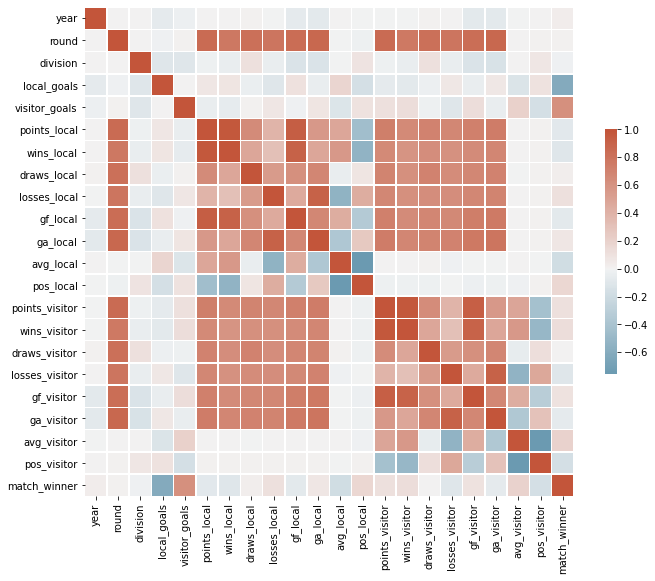

In [68]:
corr = plotting_data.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Match winner histogram 

In the following we observe the distribution of results in the three categories of the target variable.

#### Matplotlib

[]

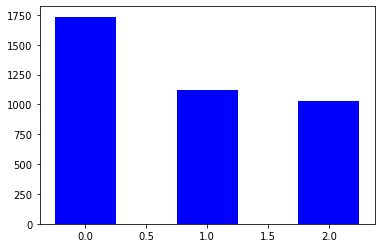

In [69]:
d = np.diff(np.unique(plotting_data['match_winner'])).min()
left_of_first_bin = plotting_data['match_winner'].min() - float(d)/2
right_of_last_bin = plotting_data['match_winner'].max() + float(d)/2
plt.hist(plotting_data['match_winner'], np.arange(left_of_first_bin, right_of_last_bin + d, d),color= 'blue', label = True, rwidth = 0.5, histtype =  'barstacked' )
plt.plot()

#### Seaborn

In [70]:
sns.color_palette(palette='pastel')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

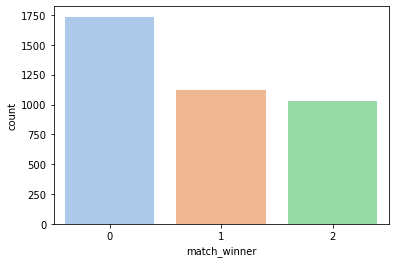

In [71]:
sns.countplot(data = plotting_data, x="match_winner", palette='pastel')

### Boxplots

Next, using a boxplot, it is shown how these variables, which are less correlated with the rest of the inputs, affect the match winner output variable. 


#### Position  

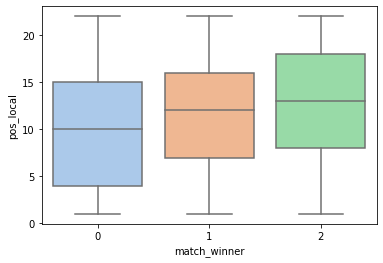

In [72]:
sns.boxplot(x="match_winner", y="pos_local", data=plotting_data, orient ='v', palette='pastel')

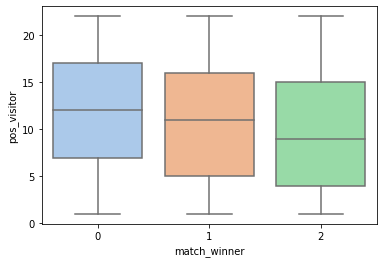

In [73]:
sns.boxplot(x="match_winner", y="pos_visitor", data=plotting_data, orient ='v', palette='pastel')

### Scatterplot

#### Average

To show the content of the average columns and to see their influence on the result of the match, scatterplots are used. In these, the average of the home and away team is set against each other and coloured according to the result of each match.

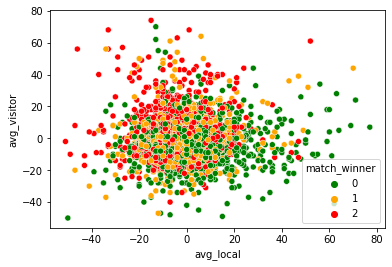

In [74]:
sns.scatterplot(data=plotting_data, x="avg_local", y="avg_visitor", hue="match_winner", palette=['green','orange','red'])

## Filtering data for plotting

In the previous plots there was a high concentration of points corresponding to all the matches contained in the dataset. We are going to plot again filtering this data (division, year, round) and limiting the number of points for each graph in order to obtain a clearer visualisation. 

### Plotting by rounds

In [75]:
plotting_data_round10 = plotting_data.loc[plotting_data['round'] <= 10]
plotting_data_round10_20 = plotting_data.loc[(10 < plotting_data['round']) & (plotting_data['round']<= 20)]
plotting_data_round20_30 = plotting_data.loc[(20 < plotting_data['round']) & (plotting_data['round']<= 30)]
plotting_data_round30 = plotting_data.loc[plotting_data['round'] > 30]

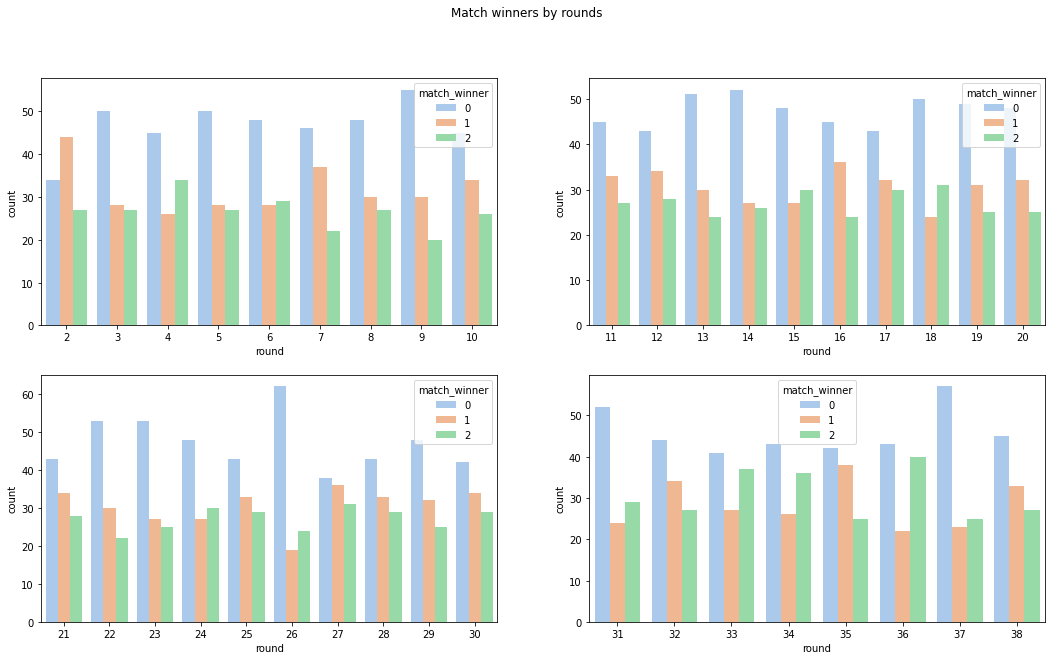

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Match winners by rounds')

sns.countplot(ax=axes[0, 0], data=plotting_data_round10, x="round", hue='match_winner', palette='pastel')
sns.countplot(ax=axes[0, 1], data=plotting_data_round10_20, x="round", hue='match_winner', palette='pastel')
sns.countplot(ax=axes[1, 0], data=plotting_data_round20_30, x="round", hue='match_winner', palette='pastel')
sns.countplot(ax=axes[1, 1], data=plotting_data_round30, x="round", hue='match_winner', palette='pastel')

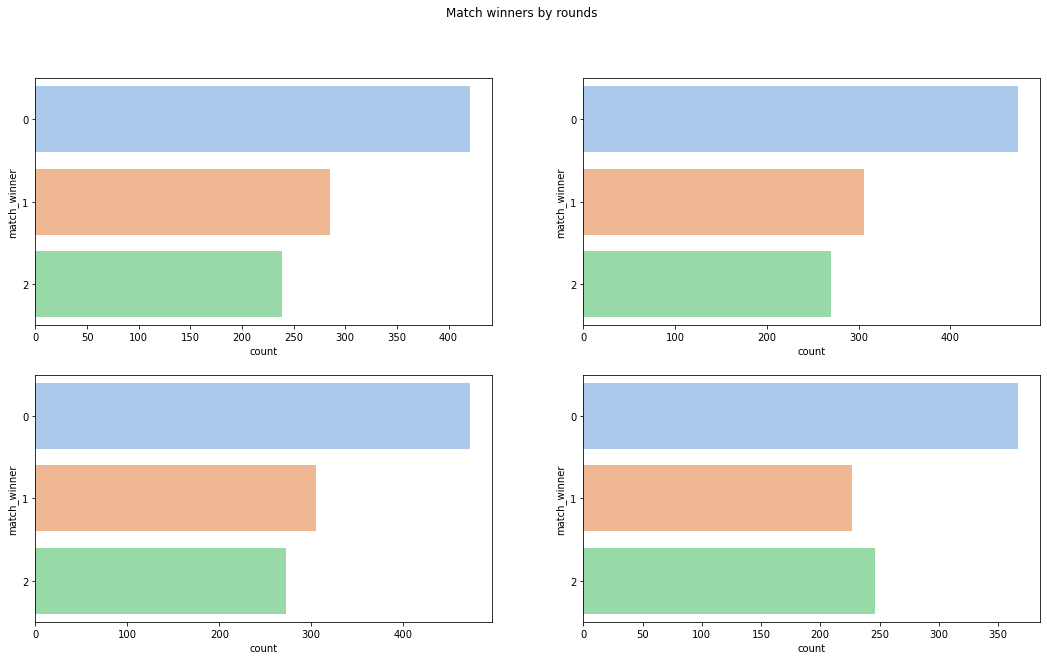

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Match winners by rounds')

sns.countplot(ax=axes[0, 0], data=plotting_data_round10, y='match_winner', palette='pastel')
sns.countplot(ax=axes[0, 1], data=plotting_data_round10_20, y='match_winner', palette='pastel')
sns.countplot(ax=axes[1, 0], data=plotting_data_round20_30, y='match_winner', palette='pastel')
sns.countplot(ax=axes[1, 1], data=plotting_data_round30, y='match_winner', palette='pastel')

After these two plots, we have been able to observe the distribution of victories per round. 

Firstly by looking at the results round by round, and in the second plot the accumulated results by packs of 10 rounds (1-10, 10-20, 20-30, 30-38).

In the first plot, a majority of home wins are maintained round by round, with a more variable ratio of draws and away wins. 

However, using the second plot, it can be seen that the proportions of home wins, away wins and draws are the same in the different phases of the season. 

It has to be taken into account that in the fourth plot the count is lower because it counts 8 rounds instead of 10.
It is interesting that in this last batch of matchdays there is a higher number of away wins than draws. This could mean that in these last games the teams take more risks and that is why the number of draws is reduced.

### Plotting by season & division 

The next filter to be imposed on the plot will be to separate the data by first and second division (Liga Santander & Liga Smartbank). 

Once filtered by divisions, it will be filtered by seasons, in order to observe if there is a different trend during the last 6 seasons. 

It is important to remember that the season is determined by the column 'year', which contains a year between 2017 and 2021 and at this point, it is important to explain that this year means the year in which the second half of the season takes place. In other words, the matches corresponding to the year 2021 are all those corresponding to season 2020-21. Similarly, the year 2017 refers to the matches of the 2016-2017 season.

In [78]:
plotting_div1 = plotting_data.loc[plotting_data['division'] == 1]
plotting_div2 = plotting_data.loc[plotting_data['division'] == 2]

In [79]:

plotting_div1_2017 = plotting_div1.loc[plotting_data['year'] == 2017]
plotting_div1_2018 = plotting_div1.loc[plotting_data['year'] == 2018]
plotting_div1_2019 = plotting_div1.loc[plotting_data['year'] == 2019]
plotting_div1_2020 = plotting_div1.loc[plotting_data['year'] == 2020]
plotting_div1_2021 = plotting_div1.loc[plotting_data['year'] == 2021]

plotting_div2_2017 = plotting_div2.loc[plotting_data['year'] == 2017]
plotting_div2_2018 = plotting_div2.loc[plotting_data['year'] == 2018]
plotting_div2_2019 = plotting_div2.loc[plotting_data['year'] == 2019]
plotting_div2_2020 = plotting_div2.loc[plotting_data['year'] == 2020]
plotting_div2_2021 = plotting_div2.loc[plotting_data['year'] == 2021]

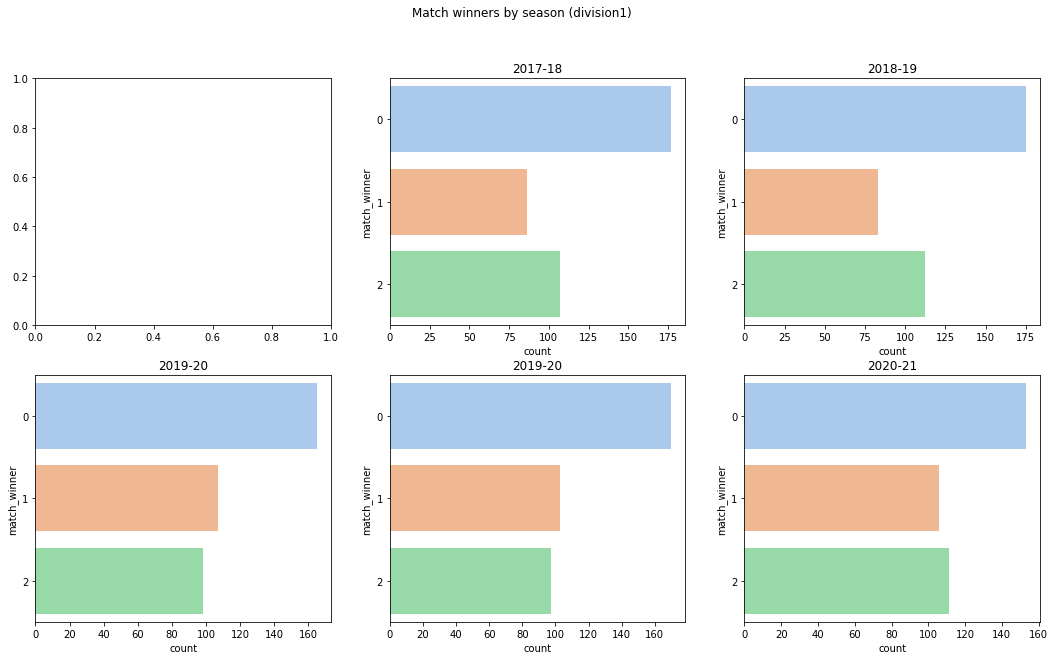

In [80]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Match winners by season (division1)')


axes[0,1].set_title('2017-18')
axes[0,2].set_title('2018-19')
axes[1,0].set_title('2019-20')
axes[1,1].set_title('2019-20')
axes[1,2].set_title('2020-21')


sns.countplot(ax=axes[0, 1], data=plotting_div1_2017, y='match_winner', palette='pastel')
sns.countplot(ax=axes[0, 2], data=plotting_div1_2018, y='match_winner', palette='pastel')
sns.countplot(ax=axes[1, 0], data=plotting_div1_2019, y='match_winner', palette='pastel')
sns.countplot(ax=axes[1, 1], data=plotting_div1_2020, y='match_winner', palette='pastel')
sns.countplot(ax=axes[1, 2], data=plotting_div1_2021, y='match_winner', palette='pastel')

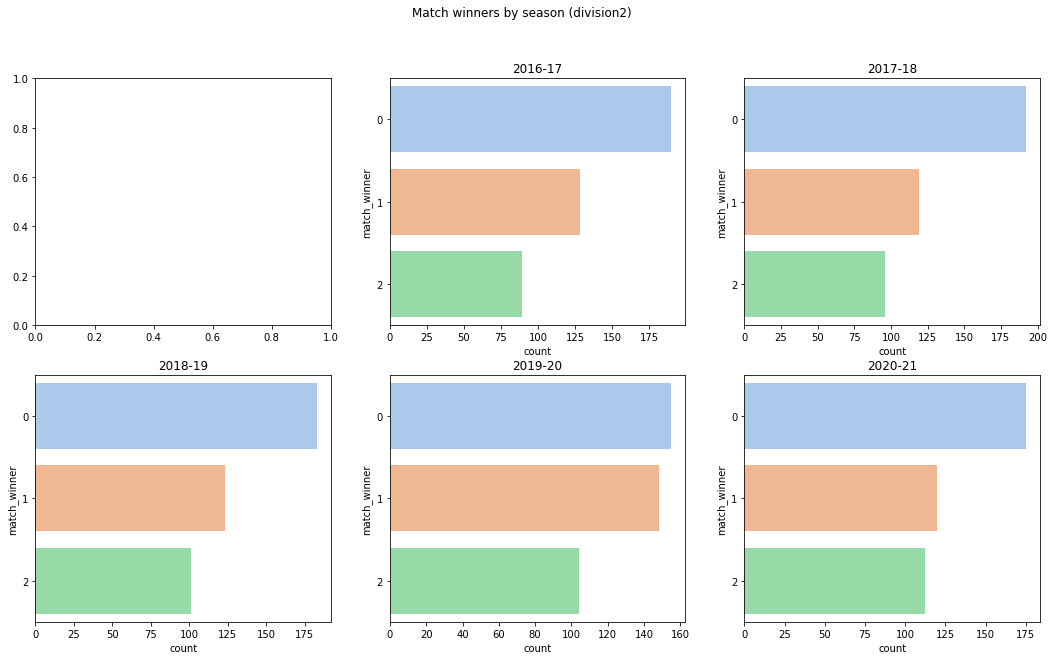

In [81]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Match winners by season (division2)')


axes[0,1].set_title('2016-17')
axes[0,2].set_title('2017-18')
axes[1,0].set_title('2018-19')
axes[1,1].set_title('2019-20')
axes[1,2].set_title('2020-21')


sns.countplot(ax=axes[0, 1], data=plotting_div2_2017, y='match_winner', palette='pastel')
sns.countplot(ax=axes[0, 2], data=plotting_div2_2018, y='match_winner', palette='pastel')
sns.countplot(ax=axes[1, 0], data=plotting_div2_2019, y='match_winner', palette='pastel')
sns.countplot(ax=axes[1, 1], data=plotting_div2_2020, y='match_winner', palette='pastel')
sns.countplot(ax=axes[1, 2], data=plotting_div2_2021, y='match_winner', palette='pastel')

#### Plotting correlated inputs

Finally, some of the variables that were most correlated with each other are plotted, which because of their significance can be considered of interest and influence on the output variable.
For this purpose, the filters established in the last plots are used.

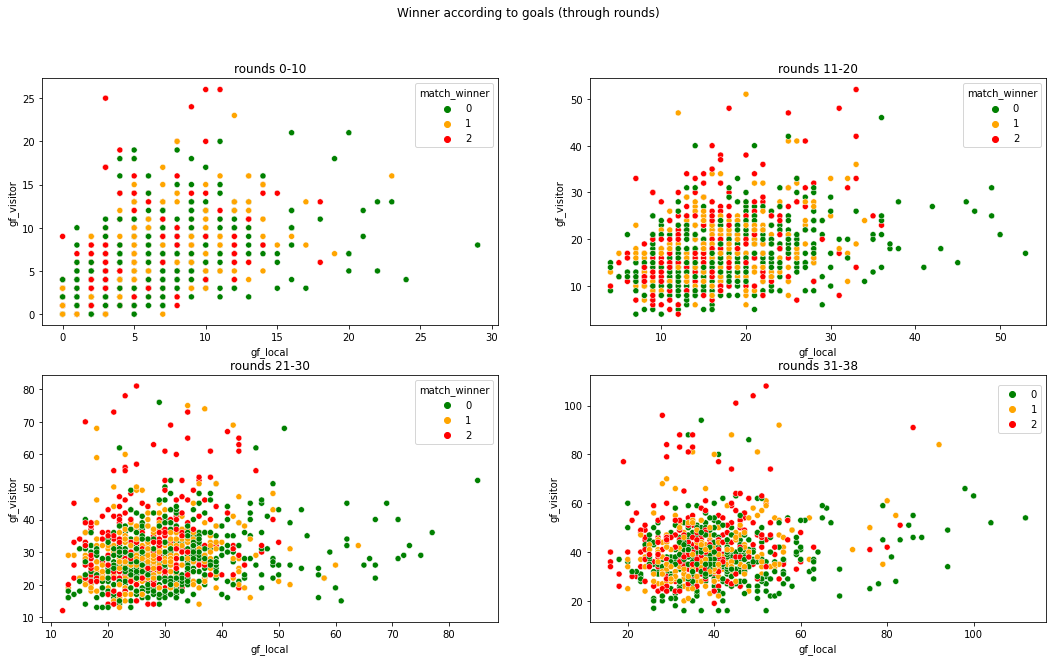

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Winner according to goals (through rounds)')

axes[0,0].set_title('rounds 0-10')
axes[0,1].set_title('rounds 11-20')
axes[1,0].set_title('rounds 21-30')
axes[1,1].set_title('rounds 31-38')


sns.scatterplot(ax=axes[0, 0], data=plotting_data_round10, x="gf_local", y="gf_visitor", hue="match_winner", palette=['green','orange','red'])
sns.scatterplot(ax=axes[0, 1], data=plotting_data_round10_20, x="gf_local", y="gf_visitor", hue="match_winner", palette=['green','orange','red'])
sns.scatterplot(ax=axes[1, 0], data=plotting_data_round20_30, x="gf_local", y="gf_visitor", hue="match_winner", palette=['green','orange','red'])
sns.scatterplot(ax=axes[1, 1], data=plotting_data_round30, x="gf_local", y="gf_visitor", hue="match_winner", palette=['green','orange','red'])

plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=1)

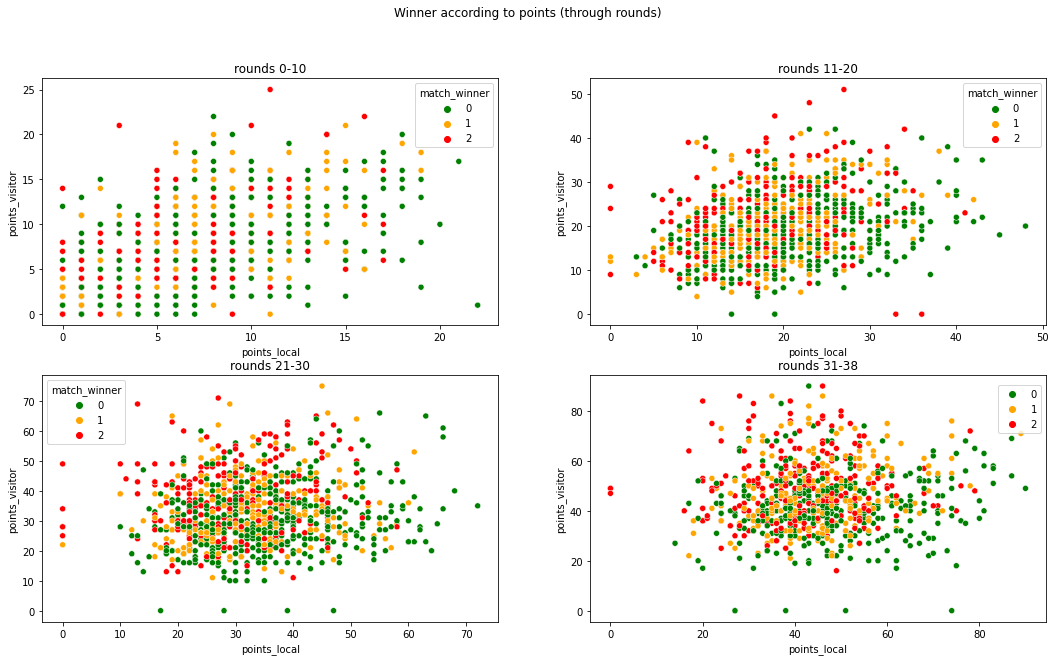

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Winner according to points (through rounds)')

axes[0,0].set_title('rounds 0-10')
axes[0,1].set_title('rounds 11-20')
axes[1,0].set_title('rounds 21-30')
axes[1,1].set_title('rounds 31-38')


sns.scatterplot(ax=axes[0, 0], data=plotting_data_round10, x="points_local", y="points_visitor", hue="match_winner", palette=['green','orange','red'])
sns.scatterplot(ax=axes[0, 1], data=plotting_data_round10_20, x="points_local", y="points_visitor", hue="match_winner", palette=['green','orange','red'])
sns.scatterplot(ax=axes[1, 0], data=plotting_data_round20_30, x="points_local", y="points_visitor", hue="match_winner", palette=['green','orange','red'])
sns.scatterplot(ax=axes[1, 1], data=plotting_data_round30, x="points_local", y="points_visitor", hue="match_winner", palette=['green','orange','red'])

plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=1)

An attempt has been made to extract information throughout this notebook thanks to the different plots made. We will continue with this work, trying to achieve more complex and interactive graphics in the front-end of this project made in Tableau.

# 05.- Scaling & Fitting

## Loading data

For this notebook we resort again to the data set used for plotting, as it will also be used for modelling in this section.

In [84]:
data = pd.read_csv('plotting_data', index_col = [0])
data.head()

,year,round,division,local_goals,visitor_goals,points_local,wins_local,draws_local,losses_local,gf_local,...,pos_local,points_visitor,wins_visitor,draws_visitor,losses_visitor,gf_visitor,ga_visitor,avg_visitor,pos_visitor,match_winner
10,2017,2,1,0,0,0,0.0,0.0,1.0,2,...,20,3,1.0,0.0,0.0,2,1,1.0,5,1
11,2017,2,1,2,2,0,0.0,0.0,1.0,4,...,17,1,0.0,1.0,0.0,1,1,0.0,12,1
12,2017,2,1,0,2,1,0.0,1.0,0.0,1,...,11,0,0.0,0.0,1.0,0,3,-3.0,19,2
13,2017,2,1,1,0,0,0.0,0.0,1.0,1,...,15,0,0.0,0.0,1.0,2,4,-2.0,18,0
14,2017,2,1,2,1,3,1.0,0.0,0.0,3,...,2,0,0.0,0.0,1.0,0,1,-1.0,16,0


It is important to drop the columns referred to the goals from the match in order to do not give this information to the model, as these columns contain information related to the result of the match, namely the goals scored by each team.

In [85]:
data = data.drop(['local_goals', 'visitor_goals'], axis=1)

## Modelling



We start with models based on this data before performing feature engineering. We will observe which classifiers obtain the best prediction values, and based on them, we will have a base prediction result that we will try to improve.

For each model, the classification report and the confusion matrix will be obtained. 

In the classification report you will be able to see the results of success in function of the metrics, they will be evaluated especially for their results in f1 score, especially the accuracy.

In the confusion matrix you will get information about the errors and successes made according to the predicted results. . The column number indicates the prediction of the model and the row number indicates the result. On the main diagonal you will find the home, draw and away successes respectively. Outside the diagonal, for example, the first column is the predictions that the model made of a home win based on what the final result was, i.e. the position corresponding to the first column and the second row is the number of matches that the model predicted as a home win that finally turned out to be a draw. The significance of the remaining elements of the matrix are also explained.

### Logistic Regression

In [86]:
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = LogisticRegression(max_iter = 500)
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.4704370179948586

In [87]:
confusion_matrix(y_test, y_pred)

array([[154,   0,  21],
       [ 97,   3,  25],
       [ 59,   4,  26]], dtype=int64)

In [88]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.50      0.88      0.64       175
        Draw       0.43      0.02      0.05       125
 Visitor win       0.36      0.29      0.32        89

    accuracy                           0.47       389
   macro avg       0.43      0.40      0.33       389
weighted avg       0.44      0.47      0.37       389



### Decision Tree

In [89]:
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = DecisionTreeClassifier()
model.fit(X_train_scaled, y_train)

predictions_dt = model.predict(X_test)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.31876606683804626

In [90]:
confusion_matrix(y_test, y_pred)

array([[66, 64, 45],
       [56, 33, 36],
       [30, 34, 25]], dtype=int64)

In [91]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, predictions_dt, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.37      0.34      0.35       175
        Draw       0.31      0.56      0.40       125
 Visitor win       0.00      0.00      0.00        89

    accuracy                           0.33       389
   macro avg       0.22      0.30      0.25       389
weighted avg       0.26      0.33      0.29       389



C:\Users\pablo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [92]:
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.4138817480719794

In [93]:
confusion_matrix(y_test, y_pred)

array([[118,  28,  29],
       [ 84,  22,  19],
       [ 50,  18,  21]], dtype=int64)

In [94]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.47      0.67      0.55       175
        Draw       0.32      0.18      0.23       125
 Visitor win       0.30      0.24      0.27        89

    accuracy                           0.41       389
   macro avg       0.37      0.36      0.35       389
weighted avg       0.38      0.41      0.38       389



### KNeighbors

In [95]:
from sklearn.neighbors import KNeighborsClassifier
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model =KNeighborsClassifier()
model.fit(X_train_scaled, y_train)

predictions = model.predict(X_test)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.39845758354755784

In [96]:
confusion_matrix(y_test, y_pred)

array([[120,  40,  15],
       [ 94,  20,  11],
       [ 47,  27,  15]], dtype=int64)

In [97]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.46      0.69      0.55       175
        Draw       0.23      0.16      0.19       125
 Visitor win       0.37      0.17      0.23        89

    accuracy                           0.40       389
   macro avg       0.35      0.34      0.32       389
weighted avg       0.36      0.40      0.36       389



# 06.- Feature Engineering

### Loading data

We go back to the data we saved in notebook 05, as it contains the same information as in plotting data and also some str type columns that we could not plot but from which we could extract information during the feature engineering.



In [98]:
df = pd.read_csv('Cleaned Data', index_col = [0])
df.tail(5)

,match_id,year,round,local,visitor,league_id,team1_id_season,team2_id_season,team1_id,team2_id,...,points_visitor,wins_visitor,draws_visitor,losses_visitor,gf_visitor,ga_visitor,avg_visitor,pos_visitor,form_visitor,match_winner
3985,91110,2021,38,Real Oviedo,Sabadell,57314,6382799,6382802,2115,2198,...,40,9.0,13.0,15.0,35,42,-7.0,19,lddww,0
3986,91104,2021,38,FC Cartagena,CD Castellón,57314,6382787,6382788,643,673,...,41,11.0,8.0,18.0,35,43,-8.0,18,wlwdd,0
3987,91112,2021,38,UD Logroñés,Girona,57314,6382792,6391868,1578,1236,...,58,16.0,10.0,11.0,39,34,5.0,6,wlwww,2
3988,91109,2021,38,Rayo Vallecano,Leganés,57314,6382798,6382791,2080,1535,...,62,18.0,8.0,11.0,41,31,10.0,4,wldwd,1
3989,91105,2021,38,Real Sporting,Lugo,57314,6382800,6382793,2125,1598,...,37,8.0,13.0,16.0,32,49,-17.0,21,lllld,0


### Creating new columns

In this notebook new columns will be created with information that can be useful to improve the results of the model. These columns will be obtained from columns that have already been elaborated as strings, or based on columns that have already been introduced in the model.

#### Results a Round before

By making use of the columns form local and form visitor new columns will be created that contain the results of the last few matches. We will transform the strings of these columns into points obtained.

In [99]:
def prev1roundlocal(col):
    if col['form_local'][0] == 'w':
        return 3
    if col['form_local'][0] == 'd':
        return 1
    if col['form_local'][0] == 'l':
        return 0

df['round-1_local'] = df.apply(lambda col: prev1roundlocal (col),axis=1)
df['round-1_local']

10      0
11      0
12      1
13      0
14      3
       ..
3985    0
3986    3
3987    3
3988    3
3989    0
Name: round-1_local, Length: 3885, dtype: int64

In [100]:
df['form_local']

10          l
11          l
12          d
13          l
14          w
        ...  
3985    ldwld
3986    wddwl
3987    wwdld
3988    wlddl
3989    llldd
Name: form_local, Length: 3885, dtype: object

In [101]:
def prev1roundvisitor(col):
    if col['form_visitor'][0] == 'w':
        return 3
    if col['form_visitor'][0] == 'd':
        return 1
    if col['form_visitor'][0] == 'l':
        return 0

df['round-1_visitor'] = df.apply(lambda col: prev1roundlocal (col), axis=1)
df['round-1_visitor'].tail()

3985    0
3986    3
3987    3
3988    3
3989    0
Name: round-1_visitor, dtype: int64

In [102]:
df.head(5)

,match_id,year,round,local,visitor,league_id,team1_id_season,team2_id_season,team1_id,team2_id,...,draws_visitor,losses_visitor,gf_visitor,ga_visitor,avg_visitor,pos_visitor,form_visitor,match_winner,round-1_local,round-1_visitor
10,96304,2017,2,Real Betis,Deportivo,30626,704145,704138,486,901,...,0.0,0.0,2,1,1.0,5,w,1,0,0
11,96276,2017,2,Espanyol,Málaga,30626,704140,704143,998,1617,...,1.0,0.0,1,1,0.0,12,d,1,0,0
12,96268,2017,2,Osasuna,R. Sociedad,30626,710097,704144,1887,2120,...,0.0,1.0,0,3,-3.0,19,l,2,1,1
13,96297,2017,2,Eibar,Valencia,30626,704139,704149,957,2647,...,0.0,1.0,2,4,-2.0,18,l,0,0,0
14,96260,2017,2,Real Madrid,Celta,30626,704146,704137,2107,712,...,0.0,1.0,0,1,-1.0,16,l,0,3,3


In order to extract information of previous rounds from columns 'form_local' & 'form_visitor' is necessary to put into the same length the strings from each row in this colums. We will fill the spaces with 'n' from none. 

In [103]:
max_length = df.form_local.map(len).max()
df.form_local = df.form_local.apply(lambda x: x + 'n'*(max_length - len(x)))
df['form_local']

10      lnnnn
11      lnnnn
12      dnnnn
13      lnnnn
14      wnnnn
        ...  
3985    ldwld
3986    wddwl
3987    wwdld
3988    wlddl
3989    llldd
Name: form_local, Length: 3885, dtype: object

In [104]:
df.form_visitor = df.form_visitor.apply(lambda x: x + 'n'*(max_length - len(x)))
df['form_visitor']

10      wnnnn
11      dnnnn
12      lnnnn
13      lnnnn
14      lnnnn
        ...  
3985    lddww
3986    wlwdd
3987    wlwww
3988    wldwd
3989    lllld
Name: form_visitor, Length: 3885, dtype: object

We create new columns assigning points to the home and away teams according to their results in the last matches. In order not to confuse the model, when we do not have information about the result of the round in question (this happens in the first rounds), we will assign an indicative value to the coefficient, different from 0, 1 and 3, so as not to confuse the lack of information with wins, draws or defeats.

#### Results two rounds before or more

In [105]:
def prevroundlocal(col, round):
    if col['form_local'][round] == 'w':
        return 3
    if col['form_local'][round] == 'd':
        return 1
    if col['form_local'][round] == 'l':
        return 0
    if col['form_local'][round] == 'n':
        return 1.5

In [106]:
def prevroundvisitor(col, round):
    if col['form_visitor'][round] == 'w':
        return 3
    if col['form_visitor'][round] == 'd':
        return 1
    if col['form_visitor'][round] == 'l':
        return 0
    if col['form_visitor'][round] == 'n':
        return 1.5

In [107]:
df['round-2_local'] = df.apply(lambda col: prevroundlocal (col, 1),axis=1)
df['round-2_visitor'] = df.apply(lambda col: prevroundvisitor (col, 1),axis=1)
df['round-3_local'] = df.apply(lambda col: prevroundlocal (col, 2),axis=1)
df['round-3_visitor'] = df.apply(lambda col: prevroundvisitor (col, 2),axis=1)
df['round-4_local'] = df.apply(lambda col: prevroundlocal (col, 3),axis=1)
df['round-4_visitor'] = df.apply(lambda col: prevroundvisitor (col, 3),axis=1)
df['round-5_local'] = df.apply(lambda col: prevroundlocal (col, 4),axis=1)
df['round-5_visitor'] = df.apply(lambda col: prevroundvisitor (col, 4),axis=1)

In [108]:
df.tail()

,match_id,year,round,local,visitor,league_id,team1_id_season,team2_id_season,team1_id,team2_id,...,round-1_local,round-1_visitor,round-2_local,round-2_visitor,round-3_local,round-3_visitor,round-4_local,round-4_visitor,round-5_local,round-5_visitor
3985,91110,2021,38,Real Oviedo,Sabadell,57314,6382799,6382802,2115,2198,...,0,0,1.0,1.0,3.0,1.0,0.0,3.0,1.0,3.0
3986,91104,2021,38,FC Cartagena,CD Castellón,57314,6382787,6382788,643,673,...,3,3,1.0,0.0,1.0,3.0,3.0,1.0,0.0,1.0
3987,91112,2021,38,UD Logroñés,Girona,57314,6382792,6391868,1578,1236,...,3,3,3.0,0.0,1.0,3.0,0.0,3.0,1.0,3.0
3988,91109,2021,38,Rayo Vallecano,Leganés,57314,6382798,6382791,2080,1535,...,3,3,0.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0
3989,91105,2021,38,Real Sporting,Lugo,57314,6382800,6382793,2125,1598,...,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


#### Coefficients of points accumulated in the last rounds

Now that there is a column created with the information of each previous round, columns are created by accumulating points obtained in the last rounds. 

This is intended to evaluate the influence of the results in the pre-match rounds for each of the teams.

In [109]:
df['pts_last1_local'] = df.apply(lambda x: x['round-1_local'], axis=1)
df['pts_last2_local'] = df.apply(lambda x: x['round-1_local'] + x['round-2_local'], axis=1)
df['pts_last2_local'].tail()

3985    1.0
3986    4.0
3987    6.0
3988    3.0
3989    0.0
Name: pts_last2_local, dtype: float64

In [110]:
print(df['round-1_local'], df['round-2_local'])

10      0
11      0
12      1
13      0
14      3
       ..
3985    0
3986    3
3987    3
3988    3
3989    0
Name: round-1_local, Length: 3885, dtype: int64 10      1.5
11      1.5
12      1.5
13      1.5
14      1.5
       ... 
3985    1.0
3986    1.0
3987    3.0
3988    0.0
3989    0.0
Name: round-2_local, Length: 3885, dtype: float64


In [111]:
df['pts_last3_local'] = df.apply(lambda x: x['round-1_local'] + x['round-2_local'] + x['round-3_local'] , axis=1)
df['pts_last4_local'] = df.apply(lambda x: x['round-1_local'] + x['round-2_local'] + x['round-3_local'] + x['round-4_local'] , axis=1)
df['pts_last5_local'] = df.apply(lambda x: x['round-1_local'] + x['round-2_local'] + x['round-3_local'] + x['round-4_local'] + x['round-5_local'], axis=1)
df['pts_last1_visitor'] = df.apply(lambda x: x['round-1_visitor'] , axis=1)
df['pts_last2_visitor'] = df.apply(lambda x: x['round-1_visitor'] + x['round-2_visitor'] , axis=1)
df['pts_last3_visitor'] = df.apply(lambda x: x['round-1_visitor'] + x['round-2_visitor'] + x['round-3_visitor']  , axis=1)
df['pts_last4_visitor'] = df.apply(lambda x: x['round-1_visitor'] + x['round-2_visitor'] + x['round-3_visitor'] + x['round-4_visitor'] , axis=1)
df['pts_last5_visitor'] = df.apply(lambda x: x['round-1_visitor'] + x['round-2_visitor'] + x['round-3_visitor'] + x['round-4_visitor'] + x['round-5_visitor'], axis=1)

In [112]:
df.tail(10)

,match_id,year,round,local,visitor,league_id,team1_id_season,team2_id_season,team1_id,team2_id,...,pts_last1_local,pts_last2_local,pts_last3_local,pts_last4_local,pts_last5_local,pts_last1_visitor,pts_last2_visitor,pts_last3_visitor,pts_last4_visitor,pts_last5_visitor
3980,91113,2021,38,Real Zaragoza,Espanyol,57314,6390092,6382789,2136,998,...,3,6.0,6.0,7.0,8.0,3,6.0,7.0,10.0,13.0
3981,91108,2021,38,Ponferradina,Albacete,57314,6382797,6382785,3287,140,...,0,1.0,2.0,5.0,5.0,0,0.0,3.0,4.0,4.0
3982,91103,2021,38,Alcorcón,Las Palmas,57314,6382786,6382790,64,2563,...,0,3.0,6.0,6.0,9.0,0,1.0,2.0,2.0,5.0
3983,91106,2021,38,Málaga,Mallorca,57314,6382794,6382795,1617,1623,...,3,6.0,7.0,7.0,7.0,3,6.0,6.0,6.0,9.0
3984,91107,2021,38,Mirandés,Fuenlabrada,57314,6382796,6387869,1699,1179,...,3,3.0,4.0,5.0,5.0,3,4.0,5.0,8.0,11.0
3985,91110,2021,38,Real Oviedo,Sabadell,57314,6382799,6382802,2115,2198,...,0,1.0,4.0,4.0,5.0,0,1.0,2.0,5.0,8.0
3986,91104,2021,38,FC Cartagena,CD Castellón,57314,6382787,6382788,643,673,...,3,4.0,5.0,8.0,8.0,3,3.0,6.0,7.0,8.0
3987,91112,2021,38,UD Logroñés,Girona,57314,6382792,6391868,1578,1236,...,3,6.0,7.0,7.0,8.0,3,3.0,6.0,9.0,12.0
3988,91109,2021,38,Rayo Vallecano,Leganés,57314,6382798,6382791,2080,1535,...,3,3.0,4.0,5.0,5.0,3,3.0,4.0,7.0,8.0
3989,91105,2021,38,Real Sporting,Lugo,57314,6382800,6382793,2125,1598,...,0,0.0,0.0,1.0,2.0,0,0.0,0.0,0.0,1.0


#### Differences between teams (avg, pts & pos) 

Three more columns are created to symbolise the differences between the two teams in terms of points average and position in the table. 

In [113]:
df['pts_difference'] = df.apply(lambda x: x['points_local'] - x['points_visitor'] , axis=1)
df['avg_difference'] = df.apply(lambda x: x['avg_local'] - x['avg_visitor'] , axis=1)
df['pos_difference'] = df.apply(lambda x: x['pos_local'] - x['pos_visitor'] , axis=1)

In [114]:
df.head(5)

,match_id,year,round,local,visitor,league_id,team1_id_season,team2_id_season,team1_id,team2_id,...,pts_last4_local,pts_last5_local,pts_last1_visitor,pts_last2_visitor,pts_last3_visitor,pts_last4_visitor,pts_last5_visitor,pts_difference,avg_difference,pos_difference
10,96304,2017,2,Real Betis,Deportivo,30626,704145,704138,486,901,...,4.5,6.0,0,1.5,3.0,4.5,6.0,-3,-5.0,15
11,96276,2017,2,Espanyol,Málaga,30626,704140,704143,998,1617,...,4.5,6.0,0,1.5,3.0,4.5,6.0,-1,-2.0,5
12,96268,2017,2,Osasuna,R. Sociedad,30626,710097,704144,1887,2120,...,5.5,7.0,1,2.5,4.0,5.5,7.0,1,3.0,-8
13,96297,2017,2,Eibar,Valencia,30626,704139,704149,957,2647,...,4.5,6.0,0,1.5,3.0,4.5,6.0,0,1.0,-3
14,96260,2017,2,Real Madrid,Celta,30626,704146,704137,2107,712,...,7.5,9.0,3,4.5,6.0,7.5,9.0,3,4.0,-14


### Introducing categorical input variable

We want to enter the id of each team as an input variable (categorical). In this way the model takes into account the behaviour of the teams in previous seasons (historical trend of the team's results). 

For this purpose, the variables corresponding to the identifiers of each equipment are used. teams ids: team1_id_season y team1_id). To use these identifiers we will use get dummies as it is a categorical variable.

The interest this may have is, if so, to detect the favouritism of a team by its club history rather than by its current situation in the season.

In [115]:
local_dummies = pd.get_dummies(df['local'])
local_dummies.columns = [item + "_local" for item in local_dummies.columns]

visitor_dummies = pd.get_dummies(df['visitor'])
visitor_dummies.columns = [item + "_visitor" for item in visitor_dummies.columns]

In [116]:
df_input = df.copy()

In [117]:
df_input = df_input.join(local_dummies)
df_input = df_input.join(visitor_dummies)

In [118]:
winner = df_input.pop('match_winner')
df_input.insert(df_input.shape[1], 'match_winner', winner)

In [119]:
df_input[['local', 'visitor', 'division', 'local_goals',
       'visitor_goals', 'result', 'winner', 'points_local', 'wins_local',
       'draws_local', 'losses_local', 'gf_local', 'ga_local', 'avg_local',
       'pos_local', 'form_local', 'points_visitor', 'wins_visitor',
       'draws_visitor']]

,local,visitor,division,local_goals,visitor_goals,result,winner,points_local,wins_local,draws_local,losses_local,gf_local,ga_local,avg_local,pos_local,form_local,points_visitor,wins_visitor,draws_visitor
10,Real Betis,Deportivo,1,0,0,0-0,0,0,0.0,0.0,1.0,2,6,-4.0,20,lnnnn,3,1.0,0.0
11,Espanyol,Málaga,1,2,2,2-2,0,0,0.0,0.0,1.0,4,6,-2.0,17,lnnnn,1,0.0,1.0
12,Osasuna,R. Sociedad,1,0,2,0-2,704144,1,0.0,1.0,0.0,1,1,0.0,11,dnnnn,0,0.0,0.0
13,Eibar,Valencia,1,1,0,1-0,704139,0,0.0,0.0,1.0,1,2,-1.0,15,lnnnn,0,0.0,0.0
14,Real Madrid,Celta,1,2,1,2-1,704146,3,1.0,0.0,0.0,3,0,3.0,2,wnnnn,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,Real Oviedo,Sabadell,2,2,1,2-1,6382799,44,9.0,17.0,11.0,38,38,0.0,14,ldwld,40,9.0,13.0
3986,FC Cartagena,CD Castellón,2,1,0,1-0,6382787,39,9.0,12.0,16.0,36,47,-11.0,20,wddwl,41,11.0,8.0
3987,UD Logroñés,Girona,2,1,4,1-4,6391868,41,10.0,11.0,16.0,25,43,-18.0,17,wwdld,58,16.0,10.0
3988,Rayo Vallecano,Leganés,2,1,1,1-1,0,57,16.0,9.0,12.0,43,36,7.0,7,wlddl,62,18.0,8.0


In [120]:
remove_columns = ['match_id','local','visitor','league_id', 'team1_id_season', 'team2_id_season', 'team1_id',
               'team2_id', 'local_abbr', 'visitor_abbr', 'local_goals', 'visitor_goals', 'result', 'winner', 
               'form_local', 'form_visitor']
featured_df = df_input[[item for item in df_input.columns if item not in remove_columns]]

In [121]:
featured_df.tail()

,year,round,division,points_local,wins_local,draws_local,losses_local,gf_local,ga_local,avg_local,...,Reus Deportiu_visitor,Sabadell_visitor,Sevilla_visitor,Sevilla At._visitor,Tenerife_visitor,UCAM Murcia_visitor,UD Logroñés_visitor,Valencia_visitor,Villarreal_visitor,match_winner
3985,2021,38,2,44,9.0,17.0,11.0,38,38,0.0,...,0,1,0,0,0,0,0,0,0,0
3986,2021,38,2,39,9.0,12.0,16.0,36,47,-11.0,...,0,0,0,0,0,0,0,0,0,0
3987,2021,38,2,41,10.0,11.0,16.0,25,43,-18.0,...,0,0,0,0,0,0,0,0,0,2
3988,2021,38,2,57,16.0,9.0,12.0,43,36,7.0,...,0,0,0,0,0,0,0,0,0,1
3989,2021,38,2,58,15.0,13.0,9.0,35,25,10.0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
for item in featured_df:
    print(item)


year
round
division
points_local
wins_local
draws_local
losses_local
gf_local
ga_local
avg_local
pos_local
points_visitor
wins_visitor
draws_visitor
losses_visitor
gf_visitor
ga_visitor
avg_visitor
pos_visitor
round-1_local
round-1_visitor
round-2_local
round-2_visitor
round-3_local
round-3_visitor
round-4_local
round-4_visitor
round-5_local
round-5_visitor
pts_last1_local
pts_last2_local
pts_last3_local
pts_last4_local
pts_last5_local
pts_last1_visitor
pts_last2_visitor
pts_last3_visitor
pts_last4_visitor
pts_last5_visitor
pts_difference
avg_difference
pos_difference
Alavés_local
Albacete_local
Alcorcón_local
Almería_local
Athletic_local
Atlético_local
Barcelona_local
Barcelona B_local
CD Castellón_local
Celta_local
Cultural Leonesa_local
Cádiz_local
Córdoba_local
Deportivo_local
Eibar_local
Elche_local
Espanyol_local
Extremadura_local
FC Cartagena_local
Fuenlabrada_local
Getafe_local
Gimnàstic Tarragona_local
Girona_local
Granada_local
Huesca_local
Las Palmas_local
Leganés_local
Leva

### Saving data for Tableau 

At this point, we distinct two different datasets. The features one, which will be used for modelling saved as a .csv file and the visualizing one, used for the front-end which will be saved as a .xls file. 

Is alredy done the featured one, we re-used df now to select the interesting columns for differents visualizations in Tableau

In [123]:
df.columns

Index(['match_id', 'year', 'round', 'local', 'visitor', 'league_id',
       'team1_id_season', 'team2_id_season', 'team1_id', 'team2_id',
       'local_abbr', 'visitor_abbr', 'division', 'local_goals',
       'visitor_goals', 'result', 'winner', 'points_local', 'wins_local',
       'draws_local', 'losses_local', 'gf_local', 'ga_local', 'avg_local',
       'pos_local', 'form_local', 'points_visitor', 'wins_visitor',
       'draws_visitor', 'losses_visitor', 'gf_visitor', 'ga_visitor',
       'avg_visitor', 'pos_visitor', 'form_visitor', 'match_winner',
       'round-1_local', 'round-1_visitor', 'round-2_local', 'round-2_visitor',
       'round-3_local', 'round-3_visitor', 'round-4_local', 'round-4_visitor',
       'round-5_local', 'round-5_visitor', 'pts_last1_local',
       'pts_last2_local', 'pts_last3_local', 'pts_last4_local',
       'pts_last5_local', 'pts_last1_visitor', 'pts_last2_visitor',
       'pts_last3_visitor', 'pts_last4_visitor', 'pts_last5_visitor',
       'pts_differen

In [124]:
frontend_df = df.drop(['match_id','league_id',
                       'team1_id_season', 'team2_id_season', 'team1_id',
                       'team2_id','local_goals','visitor_goals', 'result',
                       'winner','form_local','form_visitor','round-1_local',
                       'round-1_visitor', 'round-2_local', 'round-2_visitor',
                       'round-3_local', 'round-3_visitor', 'round-4_local', 
                       'round-4_visitor','round-5_local', 'round-5_visitor'], axis=1)


A category variable identical to match winner is created to facilitate the frontend realization. The content of both variables is the same, only the dtype changes. 
Having both variables available will facilitate representation in Tableau.

In [125]:
def categoricwinner(col):
    if col['match_winner'] == 0:
        return 'Local win'
    if col['match_winner'] == 1:
        return 'Draw'
    if col['match_winner'] == 2:
        return 'Visitor win'

frontend_df['Result'] = frontend_df.apply(lambda col: categoricwinner (col), axis=1)
frontend_df['Result'].tail()

3985      Local win
3986      Local win
3987    Visitor win
3988           Draw
3989      Local win
Name: Result, dtype: object

In [126]:
frontend_df

,year,round,local,visitor,local_abbr,visitor_abbr,division,points_local,wins_local,draws_local,...,pts_last5_local,pts_last1_visitor,pts_last2_visitor,pts_last3_visitor,pts_last4_visitor,pts_last5_visitor,pts_difference,avg_difference,pos_difference,Result
10,2017,2,Real Betis,Deportivo,BET,DEP,1,0,0.0,0.0,...,6.0,0,1.5,3.0,4.5,6.0,-3,-5.0,15,Draw
11,2017,2,Espanyol,Málaga,ESP,MAL,1,0,0.0,0.0,...,6.0,0,1.5,3.0,4.5,6.0,-1,-2.0,5,Draw
12,2017,2,Osasuna,R. Sociedad,OSA,RSO,1,1,0.0,1.0,...,7.0,1,2.5,4.0,5.5,7.0,1,3.0,-8,Visitor win
13,2017,2,Eibar,Valencia,EIB,VCF,1,0,0.0,0.0,...,6.0,0,1.5,3.0,4.5,6.0,0,1.0,-3,Local win
14,2017,2,Real Madrid,Celta,RMA,CEL,1,3,1.0,0.0,...,9.0,3,4.5,6.0,7.5,9.0,3,4.0,-14,Local win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,2021,38,Real Oviedo,Sabadell,ROV,SAB,2,44,9.0,17.0,...,5.0,0,1.0,2.0,5.0,8.0,4,7.0,-5,Local win
3986,2021,38,FC Cartagena,CD Castellón,CAR,CAS,2,39,9.0,12.0,...,8.0,3,3.0,6.0,7.0,8.0,-2,-3.0,2,Local win
3987,2021,38,UD Logroñés,Girona,UDL,GIR,2,41,10.0,11.0,...,8.0,3,3.0,6.0,9.0,12.0,-17,-23.0,11,Visitor win
3988,2021,38,Rayo Vallecano,Leganés,RAY,LEG,2,57,16.0,9.0,...,5.0,3,3.0,4.0,7.0,8.0,-5,-3.0,3,Draw


In [127]:
frontend_df.to_excel('frontend data.xls')
featured_df.to_csv('featured data')

# 07.- Modelling & Results

In [128]:
df_modelling = pd.read_csv("featured data", index_col = [0])


## Modelling

Once the dataset has been featurised, we model with different classifiers and analyse the results obtained for each of them. 

### Logistic Regression

In [129]:
features = df_modelling.values[:, :-1]
target = df_modelling.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = LogisticRegression(max_iter = 500)
model.fit(X_train_scaled, y_train)


X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.4568854568854569

In [130]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.49      0.73      0.58       335
        Draw       0.37      0.19      0.25       241
 Visitor win       0.42      0.32      0.36       201

    accuracy                           0.46       777
   macro avg       0.43      0.41      0.40       777
weighted avg       0.44      0.46      0.42       777



In [131]:
confusion_matrix(y_test, y_pred)

array([[245,  50,  40],
       [148,  46,  47],
       [110,  27,  64]], dtype=int64)

In [132]:
prediction_LR = pd.DataFrame([y_pred, y_test]).T
prediction_LR

,0,1
0,1.0,0.0
1,0.0,0.0
2,0.0,2.0
3,0.0,0.0
4,1.0,2.0
...,...,...
772,0.0,2.0
773,0.0,0.0
774,2.0,2.0
775,0.0,0.0


In [133]:
prediction_LR = prediction_LR.rename(columns={0:'pred', 1:'test'})

In [134]:
def success(col):
    if col[0] == col[1]:
        return 1
    else:
        return 0

In [135]:
prediction_LR['success'] = prediction_LR.apply(lambda col: success (col),axis=1)
prediction_LR.tail()

,pred,test,success
772,0.0,2.0,0
773,0.0,0.0,1
774,2.0,2.0,1
775,0.0,0.0,1
776,0.0,2.0,0


### Decision Tree

In [136]:
features = df_modelling.values[:, :-1]
target = df_modelling.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = DecisionTreeClassifier()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.37194337194337196

In [137]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.49      0.48      0.48       335
        Draw       0.30      0.30      0.30       241
 Visitor win       0.27      0.27      0.27       201

    accuracy                           0.37       777
   macro avg       0.35      0.35      0.35       777
weighted avg       0.37      0.37      0.37       777



In [138]:
confusion_matrix(y_test, y_pred)

array([[162,  98,  75],
       [ 98,  72,  71],
       [ 74,  72,  55]], dtype=int64)

In [139]:
prediction_DT = pd.DataFrame([y_pred, y_test]).T
prediction_DT

,0,1
0,0.0,0.0
1,0.0,0.0
2,2.0,2.0
3,0.0,0.0
4,1.0,2.0
...,...,...
772,0.0,2.0
773,0.0,0.0
774,1.0,2.0
775,1.0,0.0


In [140]:
prediction_DT = prediction_LR.rename(columns={0:'pred', 1:'test'})

In [141]:
prediction_DT['success'] = prediction_DT.apply(lambda col: success (col),axis=1)
prediction_DT.tail()

,pred,test,success
772,0.0,2.0,0
773,0.0,0.0,1
774,2.0,2.0,1
775,0.0,0.0,1
776,0.0,2.0,0


### Random Forest

In [142]:
features = df_modelling.values[:, :-1]
target = df_modelling.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.41312741312741313

In [143]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.46      0.73      0.56       335
        Draw       0.25      0.12      0.17       241
 Visitor win       0.38      0.23      0.29       201

    accuracy                           0.41       777
   macro avg       0.36      0.36      0.34       777
weighted avg       0.37      0.41      0.37       777



In [144]:
confusion_matrix(y_test, y_pred)

array([[245,  50,  40],
       [176,  30,  35],
       [114,  41,  46]], dtype=int64)

In [145]:
prediction_RF = pd.DataFrame([y_pred, y_test]).T
prediction_RF

,0,1
0,0.0,0.0
1,0.0,0.0
2,1.0,2.0
3,0.0,0.0
4,2.0,2.0
...,...,...
772,2.0,2.0
773,0.0,0.0
774,2.0,2.0
775,1.0,0.0


In [146]:
prediction_RF = prediction_RF.rename(columns={0:'pred', 1:'test'})

In [147]:
prediction_RF['success'] = prediction_RF.apply(lambda col: success (col),axis=1)
prediction_RF.tail()

,pred,test,success
772,2.0,2.0,1
773,0.0,0.0,1
774,2.0,2.0,1
775,1.0,0.0,0
776,0.0,2.0,0


### KNeighbors

In [148]:
from sklearn.neighbors import KNeighborsClassifier
features = df_modelling.values[:, :-1]
target = df_modelling.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model =KNeighborsClassifier()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.42213642213642216

In [149]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.47      0.69      0.56       335
        Draw       0.37      0.28      0.32       241
 Visitor win       0.30      0.14      0.19       201

    accuracy                           0.42       777
   macro avg       0.38      0.37      0.36       777
weighted avg       0.39      0.42      0.39       777



In [150]:
confusion_matrix(y_test, y_pred)

array([[232,  69,  34],
       [139,  67,  35],
       [127,  45,  29]], dtype=int64)

In [151]:
prediction_KN = pd.DataFrame([y_pred, y_test]).T
prediction_KN

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,2.0
3,0.0,0.0
4,1.0,2.0
...,...,...
772,0.0,2.0
773,0.0,0.0
774,0.0,2.0
775,1.0,0.0


In [152]:
prediction_KN = prediction_KN.rename(columns={0:'pred', 1:'test'})

In [153]:
prediction_KN['success'] = prediction_KN.apply(lambda col: success (col),axis=1)
prediction_KN.tail()

,pred,test,success
772,0.0,2.0,0
773,0.0,0.0,1
774,0.0,2.0,0
775,1.0,0.0,0
776,2.0,2.0,1


### SVC

In [154]:
features = df_modelling.values[:, :-1]
target = df_modelling.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = SVC()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.4543114543114543

In [155]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.46      0.90      0.61       335
        Draw       0.47      0.06      0.10       241
 Visitor win       0.41      0.18      0.25       201

    accuracy                           0.45       777
   macro avg       0.45      0.38      0.32       777
weighted avg       0.45      0.45      0.36       777



In [156]:
confusion_matrix(y_test, y_pred)

array([[303,  10,  22],
       [198,  14,  29],
       [159,   6,  36]], dtype=int64)

In [157]:
prediction_SVC = pd.DataFrame([y_pred, y_test]).T
prediction_SVC

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,2.0
3,0.0,0.0
4,2.0,2.0
...,...,...
772,0.0,2.0
773,0.0,0.0
774,0.0,2.0
775,0.0,0.0


In [158]:
prediction_SVC = prediction_SVC.rename(columns={0:'pred', 1:'test'})

In [159]:
prediction_SVC['success'] = prediction_SVC.apply(lambda col: success (col),axis=1)
prediction_SVC.tail()

,pred,test,success
772,0.0,2.0,0
773,0.0,0.0,1
774,0.0,2.0,0
775,0.0,0.0,1
776,0.0,2.0,0


To check that there is no error and that there are more predictions than 0 

In [160]:
prediction_SVC['pred'].unique()

array([0., 2., 1.])

### Gaussian Proccess Classifier

In [161]:
features = df_modelling.values[:, :-1]
target = df_modelling.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model =GaussianProcessClassifier()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.44144144144144143

In [162]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.46      0.86      0.60       335
        Draw       0.37      0.09      0.15       241
 Visitor win       0.37      0.16      0.22       201

    accuracy                           0.44       777
   macro avg       0.40      0.37      0.32       777
weighted avg       0.41      0.44      0.36       777



In [163]:
confusion_matrix(y_test, y_pred)

array([[289,  19,  27],
       [191,  22,  28],
       [151,  18,  32]], dtype=int64)

In [164]:
prediction_GPC = pd.DataFrame([y_pred, y_test]).T
prediction_GPC

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,2.0
3,0.0,0.0
4,2.0,2.0
...,...,...
772,0.0,2.0
773,0.0,0.0
774,0.0,2.0
775,1.0,0.0


In [165]:
prediction_GPC = prediction_GPC.rename(columns={0:'pred', 1:'test'})

In [166]:
prediction_GPC['success'] = prediction_GPC.apply(lambda col: success (col),axis=1)
prediction_GPC.tail()

,pred,test,success
772,0.0,2.0,0
773,0.0,0.0,1
774,0.0,2.0,0
775,1.0,0.0,0
776,0.0,2.0,0


### MLP Classifier

In [167]:
features = df_modelling.values[:, :-1]
target = df_modelling.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = MLPClassifier(max_iter=1000)
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.3912483912483912

In [168]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.47      0.46      0.47       335
        Draw       0.34      0.35      0.34       241
 Visitor win       0.33      0.32      0.33       201

    accuracy                           0.39       777
   macro avg       0.38      0.38      0.38       777
weighted avg       0.39      0.39      0.39       777



In [169]:
confusion_matrix(y_test, y_pred)

array([[155, 102,  78],
       [101,  84,  56],
       [ 75,  61,  65]], dtype=int64)

In [170]:
prediction_MLP = pd.DataFrame([y_pred, y_test]).T
prediction_MLP

,0,1
0,0.0,0.0
1,0.0,0.0
2,1.0,2.0
3,0.0,0.0
4,1.0,2.0
...,...,...
772,0.0,2.0
773,1.0,0.0
774,1.0,2.0
775,1.0,0.0


In [171]:
prediction_MLP = prediction_MLP.rename(columns={0:'pred', 1:'test'})

In [172]:
prediction_MLP['success'] = prediction_MLP.apply(lambda col: success (col),axis=1)
prediction_MLP.tail()

,pred,test,success
772,0.0,2.0,0
773,1.0,0.0,0
774,1.0,2.0,0
775,1.0,0.0,0
776,2.0,2.0,1


### AdaBoost Classifier

In [173]:
features = df_modelling.values[:, :-1]
target = df_modelling.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = AdaBoostClassifier()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.4594594594594595

In [174]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.48      0.79      0.59       335
        Draw       0.39      0.15      0.21       241
 Visitor win       0.44      0.28      0.34       201

    accuracy                           0.46       777
   macro avg       0.43      0.41      0.38       777
weighted avg       0.44      0.46      0.41       777



In [175]:
confusion_matrix(y_test, y_pred)

array([[265,  31,  39],
       [171,  35,  35],
       [121,  23,  57]], dtype=int64)

In [176]:
prediction_ADA = pd.DataFrame([y_pred, y_test]).T
prediction_ADA

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,2.0
3,0.0,0.0
4,1.0,2.0
...,...,...
772,0.0,2.0
773,0.0,0.0
774,1.0,2.0
775,2.0,0.0


In [177]:
prediction_ADA = prediction_ADA.rename(columns={0:'pred', 1:'test'})

In [178]:
prediction_ADA['success'] = prediction_ADA.apply(lambda col: success (col),axis=1)
prediction_ADA.tail()

,pred,test,success
772,0.0,2.0,0
773,0.0,0.0,1
774,1.0,2.0,0
775,2.0,0.0,0
776,0.0,2.0,0


###  GaussianNB 

In [179]:
features = df_modelling.values[:, :-1]
target = df_modelling.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = GaussianNB()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.4453024453024453

In [180]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.55      0.52      0.53       335
        Draw       0.37      0.34      0.35       241
 Visitor win       0.38      0.46      0.42       201

    accuracy                           0.45       777
   macro avg       0.43      0.44      0.43       777
weighted avg       0.45      0.45      0.45       777



In [181]:
confusion_matrix(y_test, y_pred)

array([[173,  86,  76],
       [ 86,  81,  74],
       [ 57,  52,  92]], dtype=int64)

In [182]:
prediction_GNB = pd.DataFrame([y_pred, y_test]).T
prediction_GNB

,0,1
0,1.0,0.0
1,0.0,0.0
2,2.0,2.0
3,0.0,0.0
4,1.0,2.0
...,...,...
772,0.0,2.0
773,0.0,0.0
774,2.0,2.0
775,0.0,0.0


In [183]:
prediction_GNB = prediction_GNB.rename(columns={0:'pred', 1:'test'})

In [184]:
prediction_GNB['success'] = prediction_GNB.apply(lambda col: success (col),axis=1)
prediction_GNB.tail()

,pred,test,success
772,0.0,2.0,0
773,0.0,0.0,1
774,2.0,2.0,1
775,0.0,0.0,1
776,2.0,2.0,1


###  Quadratic Discriminant Analysis 

In [185]:
features = df_modelling.values[:, :-1]
target = df_modelling.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = QuadraticDiscriminantAnalysis()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

C:\Users\pablo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.3436293436293436

In [186]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.44      0.31      0.36       335
        Draw       0.30      0.57      0.40       241
 Visitor win       0.30      0.13      0.19       201

    accuracy                           0.34       777
   macro avg       0.35      0.34      0.31       777
weighted avg       0.36      0.34      0.33       777



In [187]:
confusion_matrix(y_test, y_pred)

array([[103, 199,  33],
       [ 75, 137,  29],
       [ 58, 116,  27]], dtype=int64)

In [188]:
prediction_QDA = pd.DataFrame([y_pred, y_test]).T
prediction_QDA

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,2.0
3,1.0,0.0
4,0.0,2.0
...,...,...
772,2.0,2.0
773,2.0,0.0
774,1.0,2.0
775,0.0,0.0


In [189]:
prediction_QDA = prediction_QDA.rename(columns={0:'pred', 1:'test'})

In [190]:
prediction_QDA['success'] = prediction_QDA.apply(lambda col: success (col),axis=1)
prediction_QDA.tail()

,pred,test,success
772,2.0,2.0,1
773,2.0,0.0,0
774,1.0,2.0,0
775,0.0,0.0,1
776,0.0,2.0,0


The results obtained do not improve on those prior to feature engineering. 

Possible explanations for this result are, on the one hand, a possible overfitting problem. The model may incur this overfitting problem due to an excess of information that is too concrete, without having too large a volume of data and, therefore, learning too many details. 

On the other hand, an error may have occurred in the featurisation, but this section has been checked and the results are logical and there is no evidence that any error has been made.
The conclusion is that noise has most likely been introduced into the system with the featurisation and that is why the percentages are slightly lower.

# 08.- Analysing results

In [191]:
data = pd.read_csv('plotting_data', index_col = [0])
data.tail(5)

,year,round,division,local_goals,visitor_goals,points_local,wins_local,draws_local,losses_local,gf_local,...,pos_local,points_visitor,wins_visitor,draws_visitor,losses_visitor,gf_visitor,ga_visitor,avg_visitor,pos_visitor,match_winner
3985,2021,38,2,2,1,44,9.0,17.0,11.0,38,...,14,40,9.0,13.0,15.0,35,42,-7.0,19,0
3986,2021,38,2,1,0,39,9.0,12.0,16.0,36,...,20,41,11.0,8.0,18.0,35,43,-8.0,18,0
3987,2021,38,2,1,4,41,10.0,11.0,16.0,25,...,17,58,16.0,10.0,11.0,39,34,5.0,6,2
3988,2021,38,2,1,1,57,16.0,9.0,12.0,43,...,7,62,18.0,8.0,11.0,41,31,10.0,4,1
3989,2021,38,2,1,0,58,15.0,13.0,9.0,35,...,5,37,8.0,13.0,16.0,32,49,-17.0,21,0


In [192]:
data = data.drop(['local_goals', 'visitor_goals'], axis=1)

## Modelling non-featured

Since the results obtained with the classifiers for the featurised dataset do not improve the results obtained before the feature engineering, we now test the classifiers that were not tested with the unfeatured dataframe.

### SVC

In [193]:
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = SVC()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.435006435006435

In [194]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.45      0.90      0.60       335
        Draw       0.20      0.01      0.02       241
 Visitor win       0.37      0.17      0.23       201

    accuracy                           0.44       777
   macro avg       0.34      0.36      0.28       777
weighted avg       0.35      0.44      0.32       777



In [195]:
confusion_matrix(y_test, y_pred)

array([[302,   4,  29],
       [209,   2,  30],
       [163,   4,  34]], dtype=int64)

In [196]:
prediction_SVC = pd.DataFrame([y_pred, y_test]).T
prediction_SVC

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,2.0
3,0.0,0.0
4,0.0,2.0
...,...,...
772,2.0,2.0
773,0.0,0.0
774,0.0,2.0
775,2.0,0.0


In [197]:
prediction_SVC = prediction_SVC.rename(columns={0:'pred', 1:'test'})

In [198]:
def success(col):
    if col[0] == col[1]:
        return 1
    else:
        return 0

In [199]:
prediction_SVC['success'] = prediction_SVC.apply(lambda col: success (col),axis=1)
prediction_SVC.tail()

,pred,test,success
772,2.0,2.0,1
773,0.0,0.0,1
774,0.0,2.0,0
775,2.0,0.0,0
776,0.0,2.0,0


### Gaussian Proccess Classifier

In [200]:
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model =GaussianProcessClassifier()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.444015444015444

In [201]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.47      0.84      0.60       335
        Draw       0.33      0.04      0.07       241
 Visitor win       0.37      0.26      0.31       201

    accuracy                           0.44       777
   macro avg       0.39      0.38      0.33       777
weighted avg       0.40      0.44      0.36       777



In [202]:
confusion_matrix(y_test, y_pred)

array([[283,  10,  42],
       [185,   9,  47],
       [140,   8,  53]], dtype=int64)

In [203]:
prediction_GPC = pd.DataFrame([y_pred, y_test]).T
prediction_GPC

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,2.0
3,0.0,0.0
4,2.0,2.0
...,...,...
772,2.0,2.0
773,0.0,0.0
774,0.0,2.0
775,2.0,0.0


In [204]:
prediction_GPC = prediction_GPC.rename(columns={0:'pred', 1:'test'})

In [205]:
prediction_GPC['success'] = prediction_GPC.apply(lambda col: success (col),axis=1)
prediction_GPC.tail()

,pred,test,success
772,2.0,2.0,1
773,0.0,0.0,1
774,0.0,2.0,0
775,2.0,0.0,0
776,0.0,2.0,0


### MLP Classifier

In [206]:
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = MLPClassifier(max_iter=1000)
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.42084942084942084

In [207]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.46      0.71      0.56       335
        Draw       0.28      0.09      0.13       241
 Visitor win       0.35      0.33      0.34       201

    accuracy                           0.42       777
   macro avg       0.37      0.38      0.35       777
weighted avg       0.38      0.42      0.37       777



In [208]:
confusion_matrix(y_test, y_pred)

array([[239,  33,  63],
       [161,  21,  59],
       [114,  20,  67]], dtype=int64)

In [209]:
prediction_MLP = pd.DataFrame([y_pred, y_test]).T
prediction_MLP

,0,1
0,0.0,0.0
1,0.0,0.0
2,1.0,2.0
3,0.0,0.0
4,2.0,2.0
...,...,...
772,2.0,2.0
773,0.0,0.0
774,2.0,2.0
775,2.0,0.0


In [210]:
prediction_MLP = prediction_MLP.rename(columns={0:'pred', 1:'test'})

In [211]:
prediction_MLP['success'] = prediction_MLP.apply(lambda col: success (col),axis=1)
prediction_MLP.tail()

,pred,test,success
772,2.0,2.0,1
773,0.0,0.0,1
774,2.0,2.0,1
775,2.0,0.0,0
776,0.0,2.0,0


### AdaBoost Classifier

In [212]:
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = AdaBoostClassifier()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.4375804375804376

In [213]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.46      0.82      0.59       335
        Draw       0.33      0.07      0.11       241
 Visitor win       0.38      0.25      0.30       201

    accuracy                           0.44       777
   macro avg       0.39      0.38      0.33       777
weighted avg       0.40      0.44      0.37       777



In [214]:
confusion_matrix(y_test, y_pred)

array([[274,  19,  42],
       [186,  16,  39],
       [137,  14,  50]], dtype=int64)

In [215]:
prediction_ADA = pd.DataFrame([y_pred, y_test]).T
prediction_ADA

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,2.0
3,0.0,0.0
4,1.0,2.0
...,...,...
772,0.0,2.0
773,0.0,0.0
774,2.0,2.0
775,1.0,0.0


In [216]:
prediction_ADA = prediction_ADA.rename(columns={0:'pred', 1:'test'})

In [217]:
prediction_ADA['success'] = prediction_ADA.apply(lambda col: success (col),axis=1)
prediction_ADA.tail()

,pred,test,success
772,0.0,2.0,0
773,0.0,0.0,1
774,2.0,2.0,1
775,1.0,0.0,0
776,0.0,2.0,0


###  GaussianNB 

In [218]:
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = GaussianNB()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.435006435006435

In [219]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.53      0.56      0.55       335
        Draw       0.35      0.38      0.37       241
 Visitor win       0.36      0.29      0.32       201

    accuracy                           0.44       777
   macro avg       0.41      0.41      0.41       777
weighted avg       0.43      0.44      0.43       777



In [220]:
confusion_matrix(y_test, y_pred)

array([[187,  93,  55],
       [ 99,  92,  50],
       [ 65,  77,  59]], dtype=int64)

In [221]:
prediction_GNB = pd.DataFrame([y_pred, y_test]).T
prediction_GNB

,0,1
0,2.0,0.0
1,0.0,0.0
2,1.0,2.0
3,0.0,0.0
4,2.0,2.0
...,...,...
772,2.0,2.0
773,0.0,0.0
774,2.0,2.0
775,1.0,0.0


In [222]:
prediction_GNB = prediction_GNB.rename(columns={0:'pred', 1:'test'})

In [223]:
prediction_GNB['success'] = prediction_GNB.apply(lambda col: success (col),axis=1)
prediction_GNB.tail()

,pred,test,success
772,2.0,2.0,1
773,0.0,0.0,1
774,2.0,2.0,1
775,1.0,0.0,0
776,1.0,2.0,0


###  Quadratic Discriminant Analysis 

In [224]:
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = QuadraticDiscriminantAnalysis()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

C:\Users\pablo\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.44144144144144143

In [225]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.44      0.96      0.60       335
        Draw       0.41      0.06      0.11       241
 Visitor win       0.64      0.03      0.07       201

    accuracy                           0.44       777
   macro avg       0.49      0.35      0.26       777
weighted avg       0.48      0.44      0.31       777



In [226]:
confusion_matrix(y_test, y_pred)

array([[321,  12,   2],
       [224,  15,   2],
       [184,  10,   7]], dtype=int64)

In [227]:
prediction_QDA = pd.DataFrame([y_pred, y_test]).T
prediction_QDA

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,2.0
3,0.0,0.0
4,0.0,2.0
...,...,...
772,0.0,2.0
773,0.0,0.0
774,0.0,2.0
775,0.0,0.0


In [228]:
prediction_QDA = prediction_QDA.rename(columns={0:'pred', 1:'test'})

In [229]:
prediction_QDA['success'] = prediction_QDA.apply(lambda col: success (col),axis=1)
prediction_QDA.tail()

,pred,test,success
772,0.0,2.0,0
773,0.0,0.0,1
774,0.0,2.0,0
775,0.0,0.0,1
776,0.0,2.0,0


## Final Results 

### Logistic Regression non-featured results

In [230]:
features = data.values[:, :-1]
target = data.values[:, -1]
X, y = features, target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = LogisticRegression(max_iter = 500)
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)

np.mean(y_pred == y_test)

0.4704370179948586

In [231]:
confusion_matrix(y_test, y_pred)

array([[154,   0,  21],
       [ 97,   3,  25],
       [ 59,   4,  26]], dtype=int64)

In [232]:
target_names = ['Local win', 'Draw', 'Visitor win']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Local win       0.50      0.88      0.64       175
        Draw       0.43      0.02      0.05       125
 Visitor win       0.36      0.29      0.32        89

    accuracy                           0.47       389
   macro avg       0.43      0.40      0.33       389
weighted avg       0.44      0.47      0.37       389



In [233]:
prediction_LR = pd.DataFrame([y_pred, y_test]).T
prediction_LR

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,2.0
3,0.0,0.0
4,2.0,2.0
...,...,...
384,0.0,0.0
385,2.0,1.0
386,0.0,0.0
387,0.0,1.0


In [234]:
prediction_LR = prediction_LR.rename(columns={0:'pred', 1:'test'})

In [235]:
prediction_LR['success'] = prediction_LR.apply(lambda col: success (col),axis=1)
prediction_LR.tail()

,pred,test,success
384,0.0,0.0,1
385,2.0,1.0,0
386,0.0,0.0,1
387,0.0,1.0,0
388,2.0,2.0,1


In [236]:
recreated_X_test = pd.DataFrame(X_test, columns = data.columns[:-1])
prediction_LR = pd.concat([prediction_LR, recreated_X_test], axis=1)

In [237]:
prediction_LR.head()

,pred,test,success,year,round,division,points_local,wins_local,draws_local,losses_local,...,avg_local,pos_local,points_visitor,wins_visitor,draws_visitor,losses_visitor,gf_visitor,ga_visitor,avg_visitor,pos_visitor
0,0.0,0.0,1,2017.0,34.0,2.0,43.0,10.0,13.0,10.0,...,-2.0,10.0,46.0,13.0,7.0,13.0,38.0,34.0,4.0,8.0
1,0.0,0.0,1,2020.0,25.0,1.0,52.0,16.0,4.0,4.0,...,28.0,2.0,24.0,6.0,6.0,12.0,23.0,34.0,-11.0,16.0
2,0.0,2.0,0,2021.0,7.0,1.0,3.0,0.0,3.0,3.0,...,-4.0,20.0,4.0,1.0,1.0,4.0,3.0,8.0,-5.0,19.0
3,0.0,0.0,1,2017.0,35.0,1.0,58.0,18.0,4.0,12.0,...,5.0,7.0,20.0,4.0,8.0,22.0,27.0,72.0,-45.0,19.0
4,2.0,2.0,1,2020.0,20.0,2.0,21.0,5.0,6.0,8.0,...,-4.0,17.0,40.0,12.0,4.0,3.0,27.0,15.0,12.0,1.0


In [239]:
prediction_LR.to_excel('LogisticRegression_prediction.xls', )